In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import csv
#import pandasql as ps
import matplotlib.pyplot as plt
#import shapefile as shp
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split
#import pysal as ps
import scipy

#import torch
#import torch.nn as nn
#import torch.nn.parallel
#import torch.optim as optim
#import torch.utils.data

#from torch.nn import functional
#from torch.autograd import Variable

import statistics

#temporal pattern clustering
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from sklearn import metrics
from scipy.cluster.hierarchy import fcluster
from scipy.stats import chisquare
from scipy.stats import wasserstein_distance

#regression model
from patsy import dmatrices
#import statsmodels.api as sm

from datetime import datetime

#from pysal.model import spreg
#from pysal.lib import weights
#from pysal.explore import esda

#calculate the demographic bias 
#use wasserstein_distance
from scipy.stats import wasserstein_distance

#path = 'C:/Users/29700/Downloads/RecSys-Workshop/tutorials/'
#os.chdir(path)
#import utilities as utl

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mae
from datetime import datetime
import time
from sklearn.decomposition import NMF

import time
import scipy.sparse
from scipy.stats import entropy
from sys import exit

import itertools
from itertools import permutations

import xml.etree.ElementTree as ET

import geopandas as gpd

import copy 

import json

#binary factorization
import nimfa

from sklearn.decomposition import NMF
import scipy.sparse as sparse
import implicit

In [2]:
input_path = 'G:/My Drive/2021/Bias/SUMO_simulation/appsim/'
os.chdir(input_path)

In [3]:
def get_time_variationbyzone(data, taz, time_loc, plot_index):
    data_taz = data[data['taz']==taz]
    data_taz = data_taz.sort_values(by=['hr', 'min'])
    data_taz = data_taz.groupby(by=['hr', 'min']).sum()
    
    data_taz.reset_index(inplace=True)
    data_taz = data_taz[['hr','min','sum']]
    #data_taz
    obs_sum = np.zeros((len(time_loc)))
    hr_ = data_taz['hr'].values
    min_ = data_taz['min'].values
    sum_val = data_taz['sum'].values
    
    for i in range(len(hr_)):
        obs_sum[time_loc[str(hr_[i])+'_'+str(min_[i])]] = sum_val[i]
    #use obs/max(obs) instead of obs/sum(obs) 
    obs_per = obs_sum/(np.max(obs_sum))
    
    if plot_index == True:
        fig = plt.figure(taz)
        plt.plot(obs_sum)
    return(obs_per)

def get_sim_obs_ts(fcd_out, taz_time_per, avg_per, return_sim=True):
    taz_ = fcd_out['taz'].values
    time_5 = fcd_out['time_5'].values
    per_ts = []
    for i in range(len(taz_)):
        if taz_[i] in taz_time_per:
            per_ts.append(taz_time_per[taz_[i]][time_5[i]])
        else:
            per_ts.append(avg_per[time_5[i]])
    if return_sim == True:
        sim_obs_ts = [] 
        for i in range(len(per_ts)):
            sim_obs_ts.append(np.random.binomial(1, per_ts[i], 1)[0])
        return(sim_obs_ts)
    else:
        return(per_ts)
    

#convert dt to matrix
def read_fcd(fcd_dt_path, app_based_data):
    fcd_out = pd.read_csv(fcd_dt_path, header=None)
    fcd_out.columns = ['id', 'taz', 'time']
    fcd_out.taz = fcd_out.taz.astype('int')
    
    
    revise_dt = lambda x: x.split('-')[0] if '-' in x else x
    get_sample_index = lambda x: x.split('-')[2] if '-' in x else 3
    fcd_out['reids'] = fcd_out['id'].apply(revise_dt)
    fcd_out['sample_index'] = (fcd_out['id'].apply(get_sample_index)).astype(int)
    
    fcd_out['time'] = fcd_out['time'].astype('int')
    fcd_out['hr'] = (fcd_out['time'].values/3600).astype(int)
    fcd_out['minus'] = ((fcd_out['time'].values- fcd_out['hr'].values*3600)/60).astype(int)
    fcd_out['time_30'] = (fcd_out['time']/30).astype(int)
    fcd_out['time_5'] = (fcd_out['time']/300).astype(int)
    
    print('num id', len(np.unique(fcd_out.reids)))

    #fcd_out.sort_values(by=['time', 'taz'])
    fcd_out['tl_id'] = fcd_out['taz'].astype(str)+'_'+(fcd_out['time_5']).astype(str)

    time_ = np.unique((fcd_out['time']/300).astype(int))
    
    if app_based_data == True:
        #sample index 0: non app-based samples, 1: app=based samples, 3: transit
        #fcd_out.groupby(by=['sample_index']).size()
        #sample_index 0    1714901, 1     572267, 3     180802
        return(fcd_out[fcd_out['sample_index']!=0])
    else:
        return(fcd_out)
    
def getfcdnorigindt(fcd_out, savepath, 
                    data_obs, time_loc, taz_time_per, avg_per, 
                    save_index):
    #get one day data (use 5 min as the time interval)
    #fcd_out = fcd_out[fcd_out['time_5']<288]
    newuser_ = {}
    index_ = 0
    for i in np.unique(fcd_out.reids):
        newuser_[i] = index_
        index_ += 1    
    ## fcd output processing
    #delete the data exceeds the 24-hr daily period
    #fcd_out = fcd_out[~fcd_out['time'].isin([86400, 86700])]
    fcd_out.time = fcd_out.time.astype('int')

    obs = data_obs.groupby(by=['time']).size().values
    obs_per = obs/max(obs)

    sample_ct = lambda x: np.random.binomial(1, obs_per[x], 1)[0]

    fcd_out['sim_obs'] = fcd_out['time_5'].apply(sample_ct)

    fcd_out['tl_id'] = fcd_out['taz'].astype(str)+'_'+((fcd_out['time']/300).astype(int)).astype(str)
    
    sim_obs = get_sim_obs_ts(fcd_out, taz_time_per, avg_per, True)
    fcd_out['sim_obs_ts'] = sim_obs

    #simulated observations based on time variation
    print('sim based on time', 
          np.count_nonzero(fcd_out['sim_obs'])/fcd_out.shape[0])

    #simulated observations based on time and spatial variation
    print('sim based on time and spatial',
          np.count_nonzero(fcd_out['sim_obs_ts'])/fcd_out.shape[0])
    
    return(fcd_out)

#fcd_out = read_fcd(fcd_dt_path, app_based_data)
def run_sim(csv_path, fcd_out, savepath, save_index=False, plot_index=True):
    data_obs = pd.read_csv(csv_path, header=0)
    print('app based data', data_obs.head(3))
    
    newids = np.unique(data_obs.newid)
    newid_ = {}
    index_ = 0
    for i in range(len(newids)):
        newid_[newids[i]] = index_
        index_ += 1
        
    get_hr = lambda x: x.split(':')[0]
    get_min = lambda x: x.split(':')[1]

    hr_ = np.unique(data_obs['time'].astype(str).apply(get_hr).astype(int))
    min_ = np.unique(data_obs['time'].astype(str).apply(get_min).astype(int))
    taz_ = np.unique(data_obs['taz'])

    data_obs['hr'] = data_obs['time'].astype(str).apply(get_hr).astype(int)
    data_obs['min'] = data_obs['time'].astype(str).apply(get_min).astype(int)
    
    index_ = 0
    lt_loc = {}
    for taz in taz_:
        for h in hr_:
            for m in min_:
                lt_loc['4_'+str(h)+'_'+str(m)+'_'+str(taz)] = index_
                index_ += 1
    obs_mx = np.zeros((len(newid_), len(lt_loc)))

    newid_col = data_obs.newid.values
    key_col = data_obs.key.values
    ct_col = data_obs['sum'].values

    for i in range(len(newid_col)):
        obs_mx[newid_[newid_col[i]]][lt_loc[key_col[i]]] = 1

    total_ct = np.sum(obs_mx, axis=0)
    #get ct based on taz and time
    total_ct = total_ct.reshape(1, total_ct.shape[0])
    total_ct_conver = np.hsplit(total_ct, len(taz_))
    max_num = np.max(np.array(total_ct_conver), axis=2)
    
    if plot_index == True:
        plt.plot(data_obs.groupby(by=['time']).size().values)
        
    time_loc = {}
    index_ = 0
    for hr in hr_:
        for miuts in min_:
            time_loc[str(hr)+'_'+str(miuts)] = index_
            index_ += 1

    taz_time_per = {}
    avg_per = 0
    index_ = 0 
    for taz_id in taz_:
        taz_time_per[taz_id] = get_time_variationbyzone(data_obs, taz_id, time_loc, plot_index)
        if index_ == 0:
            avg_per = taz_time_per[taz_id]
        else:
            avg_per = avg_per + taz_time_per[taz_id]
        index_ += 1
        
    avg_per = avg_per/np.max(avg_per)
    if plot_index == True:
        fig = plt.figure(1)
        plt.plot(avg_per)
        
    
    fcd_out = getfcdnorigindt(fcd_out, savepath, data_obs, time_loc, taz_time_per, avg_per, save_index=False)
    
    fcd_out['obs'] = 1
    #simulation compare
    print('sim_t vs sim_ts', mean_squared_error(fcd_out.sim_obs, fcd_out.sim_obs_ts, squared=False))
    print('obs vs sim_ts', mean_squared_error(fcd_out.obs, fcd_out.sim_obs_ts, squared=False))
    print('obs vs sim_t', mean_squared_error(fcd_out.obs, fcd_out.sim_obs, squared=False))
    
    return(fcd_out)   


def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def get_maxvalnindex(WHpert):
    max_val = np.max(WHpert, axis=1)
    max_index = np.argmax(WHpert, axis=1)
    return(max_val, max_index)

def get_pred_dt(WH_pred, time_interval):
    num_taz = int(WH_pred.shape[1]/time_interval)
    #print('num taz', num_taz)
    pred_time_dic = get_pred_timedict(num_taz, time_interval)
    for t in pred_time_dic:
        pred_val = WH_pred[:, pred_time_dic[t]]
        if t == 0:
            max_val, max_index = get_maxvalnindex(pred_val)
        else:
            max_val_cur, max_index_cur = get_maxvalnindex(pred_val)
            max_val = np.vstack((max_val, max_val_cur))
            max_index = np.vstack((max_index, max_index_cur))
    return(max_val.T, max_index.T)  


def get_simdt(fcd_out, sim_col, newuser_, loc_time):
    sim_dt = np.zeros((len(newuser_), len(loc_time)))
    fcd_obs = fcd_out[['reids', 'tl_id', 'sim_obs']].groupby(by=['reids', 'tl_id']).sum()
    fcd_obs.reset_index(inplace=True) 
    ids_ = fcd_obs['reids'].values
    tl_id_ = fcd_obs['tl_id'].values
    sim_obs = fcd_obs['sim_obs'].values
    for i in range(len(ids_)):
        sim_dt[newuser_[ids_[i]]][loc_time[tl_id_[i]]] = sim_obs[i]
    return(sim_dt)

def fit_dt(fcd_out, sim_col, newuser_, loc_time, k_val): 
    sim_dt = get_simdt(fcd_out, sim_col, newuser_, loc_time)
    #predict data based on time
    model = NMF(n_components=k_val, init='random', random_state=0)
    W = model.fit_transform(sim_dt)
    H = model.components_
    return(np.dot(W, H))

def get_index_lst(i, num_taz, num_time):
    return(list(np.arange(i, (num_time-1)*num_taz+i, num_time)))

#sep_dict = {'mor':[6, 9]
#            'noon':[9, 17]
#            'eve':[17, 20]}
def sep_indexdetime(num_taz, num_time, time_interval):
    sep_time = {'mor':[],
               'noon':[],
               'eve':[],
               'other':[]}
    for i in range(num_time):
        if i>=6*time_interval and i < 9*time_interval:
            sep_time['mor'].extend(get_index_lst(i, num_taz, num_time))
        elif i >= 9*time_interval and i < 17*time_interval:
            sep_time['noon'].extend(get_index_lst(i, num_taz, num_time))
        elif i>17*time_interval and i <20*time_interval:
            sep_time['eve'].extend(get_index_lst(i, num_taz, num_time))
        else:
            sep_time['other'].extend(get_index_lst(i, num_taz, num_time))
            
    for key in sep_time:
        sep_time[key] = sorted(sep_time[key])
    return(sep_time)

def fit_dtbytime(sim_dt, num_taz, num_time, time_interval, k_val, save_name):
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    for ky in time_dict:
        #print(ky)
        input_dt = sim_dt[:, time_dict[ky]]
        model = NMF(n_components=k_val, init='random', random_state=0)
        W = model.fit_transform(sim_dt)
        H = model.components_
        WH = np.dot(W, H)
        WH_max, WH_index = get_pred_dt_time(WH, 288)
        pd.DataFrame(WH_max).to_csv('WH_max_'+ky+'_'+save_name+'.csv')
        pd.DataFrame(WH_index).to_csv('WH_index'+ky+'_'+save_name+'.csv')

def del_transit_oneobs(fcd_out):
    fcd_transit = fcd_out[fcd_out['sample_index']==3]
    fcd_transit = fcd_transit.groupby(by=['id']).size().to_frame()
    fcd_transit.reset_index(inplace=True)
    fcd_transit_ids = fcd_transit[['id']][fcd_transit[0]==1].values.flatten()
    #print(fcd_transit_ids)
    print('# o ftransit line with only one obs deleted', len(fcd_transit_ids))
    return(fcd_out[~fcd_out['id'].isin(fcd_transit_ids)])

def get_test_dt(fcd_out, selected_ids):
    fcd_test = (fcd_out[fcd_out['reids'].isin(selected_ids)]).sort_values(by=['reids', 'time_30'])
    fcd_test['od_taz'] = fcd_test['otaz'].astype(str)+'_'+fcd_test['dtaz'].astype(str)
    fcd_test = fcd_test.sort_values(by=['reids', 'time_30'])
    return(fcd_test)

def get_other_stay_od(fcd_ids):
    fcd_ids['otaz'] = fcd_ids['taz']
    fcd_ids['dtaz'] = fcd_ids[['taz']].shift(periods=-1, fill_value=fcd_ids['otaz'].values[-1])
    fcd_ids['od_taz'] = fcd_ids['otaz'].astype(str)+'_'+fcd_ids['dtaz'].astype(str)
    return(fcd_ids)

def get_stay_val(fcd_test, ids, other_index):
    fcd_ids = fcd_test[fcd_test['reids']==ids]
    if other_index == True:
        fcd_ids = get_other_stay_od(fcd_ids)

    fcd_index = fcd_ids.groupby(by=['od_taz', 'otaz','dtaz','time_5_new'], sort=False).size().to_frame()
    fcd_index.reset_index(inplace=True)
    fcd_index = fcd_index.sort_values(by=['time_5_new'])

    fcd_index['time_diff'] = fcd_index[['time_5_new']] - (fcd_index[['time_5_new']].shift(periods=1, fill_value=0))
    fcd_index['time_diff_index'] = fcd_index['time_diff']>1

    start_t = 0
    time_ = []
    taz_ = []
    first_index = False

    for i in range(fcd_index.shape[0]):
        #handle special condition, when the first index = 1
        if i == 0 and fcd_index.iloc[i, 5] == 1:
            first_index = True
        if fcd_index.iloc[i, 6] == True or first_index==True:
            add_time = np.arange(start_t, fcd_index.iloc[i, 3])
            time_.extend(add_time)
            taz_.extend(np.repeat(fcd_index.iloc[i, 1], len(add_time)))

        start_t = fcd_index.iloc[i, 3]+1

    if start_t-1 < 287:
        add_time = np.arange(start_t, 288)
        time_.extend(add_time)
        taz_.extend(np.repeat(fcd_index.iloc[i, 2], len(add_time)))
        
    return(np.vstack((np.repeat(ids, len(time_)), time_, taz_)))

def get_stays_mx(fcd_dt, selected_ids, other_index=False):
    fcd_test = get_test_dt(fcd_dt, selected_ids)
    index_ = 0
    for ids in np.unique(fcd_test['reids']):
        if index_ == 0:
            add_stay = get_stay_val(fcd_test, ids, other_index)
            index_ = 1
        else:
            add_stay_cur = get_stay_val(fcd_test, ids, other_index)
            add_stay = np.hstack((add_stay, add_stay_cur))
            
    return(add_stay.T)

#check add stay function
def add_stay_check(add_stay, selected_ids, fcd_out):
    #get fcd trip num based on the time
    fcd_trip_num = (fcd_out.sort_values(by=['reids', 'time_30'])).groupby(by=['reids', 'time_5'], sort=False).size().to_frame()
    fcd_trip_num.reset_index(inplace=True)
    fcd_trip_num = fcd_trip_num.groupby(by=['reids'], sort=False).size().to_frame()
    fcd_trip_num.reset_index(inplace=True)
    
    test = pd.DataFrame(add_stay)
    test.columns = ['reids', 'taz', 'time_5']
    test = test.groupby(by=['reids']).size().to_frame()
    test.columns = ['stay_num']
    test = test.join((fcd_trip_num[fcd_trip_num['reids'].isin(selected_ids)]).set_index('reids'))
    test.reset_index(inplace=True)
    test = test[~(test['reids'].isin(stays_[0].values))]
    test.columns = ['reids','stay_num', 'trip_num']
    test['total'] = test['stay_num']+test['trip_num']
    print(test['total'].describe())
    return(test[test['total']!=288])

#add ids with stays only
#time = np.range(0, 288)
def get_stays(stays_dt):
    for i in range(stays_dt.shape[0]):
        ids = stays_dt.iloc[i, 0]
        taz = stays_dt.iloc[i, 1]
        if i == 0 :
            stays = np.vstack((np.repeat(ids, 288),
                               np.arange(0, 288),
                               np.repeat(taz, 288)))
        else:
            stays = np.hstack((stays, np.vstack((np.repeat(ids, 288),
                                                 np.arange(0, 288),
                                                 np.repeat(taz, 288)))))
        
    return(stays.T)

def add_index(index_val, stay_mx):
    add_index = np.repeat(index_val, stay_mx.shape[0]).reshape(stay_mx.shape[0], 1)
    return(np.hstack((stay_mx, add_index)))

def join_dt(add_mx, colname, index_val):
    add_mx = add_index(index_val, add_mx)
    join_dt = pd.DataFrame(add_mx)
    join_dt.columns = colname
    return(join_dt)
    

#colname = ['reids', 'time_5', 'taz'], indexcol = 'col_index'
def get_filled_dt(stay, add_stay, add_stay_other, fcd_out, colname, indexcol):
    #add index to distinguish the filled dt
    fcd_dt = fcd_out[colname]
    fcd_dt[indexcol] = 3
    colname.append(indexcol)
    
    #add add stays
    fcd_dt = pd.concat([fcd_dt, join_dt(add_stay, colname, 0)])
    #add add other stays
    fcd_dt = pd.concat([fcd_dt, join_dt(add_stay_other, colname, 1)])
    #add stays only
    fcd_dt = pd.concat([fcd_dt, join_dt(stay, colname, 2)])
    
    return(fcd_dt.sort_values(by=['reids', 'time_5_new']))

def conver2mx(test_taz_time, taz_dict):
    time_len = len(np.unique(test_taz_time['minut_5']))
    taz_len = len(taz_dict)
    output_mx = np.zeros((taz_len, time_len))
    taz_val = test_taz_time.taz.values
    time_val = test_taz_time.minut_5.values
    num_val = test_taz_time[0].values 
    for i in range(test_taz_time.shape[0]):
        output_mx[taz_val[i]][time_val[i]] = num_val[i]
    return(output_mx)

def cal_time_taz_per(test_taz, test_taz_time, taz_dict):
    output_per = conver2mx(test_taz_time, taz_dict)
    print(output_per.shape)
    taz_ = test_taz_.taz.values
    num_ids = test_taz_[0].values
    
    missing_taz = []
    for i in range(output_per.shape[0]):
        if i in taz_:
            output_per[i, :] = output_per[i, :]/(num_ids[np.where(taz_==167)[0][0]])
        else:
            missing_taz.append(i)
    print('# of missing tazs', len(missing_taz))
    #add average data to the tazs without data info
    mean_per = np.sum(output_per, axis=0)/(len(taz_)-len(missing_taz))
    for i in missing_taz:
        output_per[i,:] = mean_per
    return(output_per)

#######
#get the simulated observed data
def check_fcd_dt(fcd_dt):
    fcd_colname = fcd_dt.columns
    id_dict = {}
    index_ = 0
    for i in np.unique(fcd_dt['reids']):
        if i not in id_dict:
            id_dict[i] = index_
            index_ += 1

    get_id_index = lambda x: id_dict[x]        
    fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
    if 'ts_index' not in fcd_colname:
        fcd_dt['ts_index'] = fcd_dt['taz_index']*288 + fcd_dt['time_5_new']
    return(fcd_dt)

#get the simulated observed data
def getinput_mx(fcd_dt, sim_col):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    fcd_val = check_fcd_dt(fcd_val)
    #fcd_dt['ts_index'] = fcd_dt['taz_index']*288+fcd_dt['time_5_new'] 

    fcd_val = check_fcd_dt(fcd_val)
    input_mx = np.zeros((len(np.unique(fcd_val['reids'])),
                         len(np.unique(fcd_val['time_5_new']))*len(np.unique(fcd_val['taz_index']))))
   # print(input_mx.shape)
    
    vals = fcd_val[sim_col].values
    rows = fcd_val['id_index'].values
    cols = fcd_val['ts_index'].values
    for i in range(len(vals)):
        input_mx[rows[i], cols[i]] = vals[i]        
    return(input_mx)

def fit_dt01(fcd_dt, sim_col, k_val): 
    sim_dt = getinput_mx(fcd_dt, sim_col)
    #predict data based on time
    #for 0 and 1
    model = NMF(n_components=k_val, init='random', 
                random_state=0, solver='cd', 
                beta_loss='binary_reconstruction')
    
    W = model.fit_transform(sim_dt)
    H = model.components_
    return(np.dot(W, H))

def fit_dtbytime_stay01(fcd_dt, sim_col, time_interval, k_val, save_name):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    num_taz = len(np.unique(fcd_dt['taz_index']))
    num_time = len(np.unique(fcd_dt['time_5_new']))
    sim_dt = getinput_mx(fcd_dt, sim_col)
    
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    for ky in time_dict:
        #print(ky)
        input_dt = sim_dt[:, time_dict[ky]]
        model = NMF(n_components=k_val, init='random', 
                    random_state=0, solver='cd', 
                    beta_loss='binary_reconstruction')
        W = model.fit_transform(sim_dt)
        H = model.components_
        WH = np.dot(W, H)
        WH_max, WH_index = get_pred_dt_time(WH, 288)
        pd.DataFrame(WH_max).to_csv('WH_max_stay_'+ky+'_'+save_name+'.csv')
        pd.DataFrame(WH_index).to_csv('WH_index_stay_'+ky+'_'+save_name+'.csv')
    print('predtion based on time done')

def fit_dt(fcd_dt, sim_col, k_val): 
    sim_dt = getinput_mx(fcd_dt, sim_col)
    #predict data based on time
    #for 0 and 1
    model = NMF(n_components=k_val, init='random', random_state=0)
    
    W = model.fit_transform(sim_dt)
    H = model.components_
    return(np.dot(W, H))

def fit_dtbytime_stay(fcd_dt, sim_col, time_interval, k_val, save_name):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    num_taz = len(np.unique(fcd_dt['taz_index']))
    num_time = len(np.unique(fcd_dt['time_5_new']))
    sim_dt = getinput_mx(fcd_dt, sim_col)
    
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    for ky in time_dict:
        #print(ky)
        input_dt = sim_dt[:, time_dict[ky]]
        model = NMF(n_components=k_val, init='random', random_state=0)
        W = model.fit_transform(sim_dt)
        H = model.components_
        WH = np.dot(W, H)
        WH_max, WH_index = get_pred_dt(WH, 288)
        pd.DataFrame(WH_max).to_csv('WH_max_stay_'+ky+'_'+save_name+'.csv')
        pd.DataFrame(WH_index).to_csv('WH_index_stay_'+ky+'_'+save_name+'.csv')
    print('predtion based on time done')

#get time loc
#time_interval = 288
#num_taz = int(WH_ts.shape[1]/time_interval)

def get_timeloc(num_taz, time_interval, t):
    select_time_loc = []
    for i in range(num_taz):
        select_time_loc.append(time_interval*i+t)
    return(select_time_loc)

def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def get_maxvalnindex(WHpert):
    max_val = np.max(WHpert, axis=1)
    max_index = np.argmax(WHpert, axis=1)
    return(max_val, max_index)


def get_pred_dt_time(WH_pred, time_interval):
    num_taz = int(WH_pred.shape[1]/time_interval)
    print('num taz', num_taz)
    pred_time_dic = get_pred_timedict(num_taz, time_interval)
    for t in pred_time_dic:
        pred_val = WH_pred[:, pred_time_dic[t]]
        if t == 0:
            max_val, max_index = get_maxvalnindex(pred_val)
        else:
            max_val_cur, max_index_cur = get_maxvalnindex(pred_val)
            max_val = np.vstack((max_val, max_val_cur))
            max_index = np.vstack((max_index, max_index_cur))
    return(max_val.T, max_index.T)  

In [4]:
#read fcd_dt
path = "G:/My Drive/2021/Bias/SUMO_simulation/appsim/"
os.chdir(path)

In [122]:
trip_stay = pd.read_csv('cuebiq_stay_trip_DtSeattle.csv')
#trip_stay = pd.read_csv('cuebiq_stay_trip.csv')

get_5min = lambda x: datetime.fromtimestamp(x).hour*12 + datetime.fromtimestamp(x).minute//5
get_min = lambda x: datetime.fromtimestamp(x).minute
get_hr = lambda x: datetime.fromtimestamp(x).hour

trip_stay['5min'] = trip_stay['0'].apply(get_5min)
#trip_stay['min'] = trip_stay['0'].apply(get_min)
#trip_stay['hr'] = trip_stay['0'].apply(get_hr)

trip_stay_ct = trip_stay.groupby(by=['day', '5min']).size().to_frame()
trip_stay_ct.reset_index(inplace=True)

trip_stay_ct = trip_stay_ct.pivot(index=['day'], columns='5min', values=[0])
trip_stay_ct.columns = trip_stay_ct.columns.droplevel()
trip_stay_ct = trip_stay_ct.rename_axis(None,axis=1)
trip_stay_ct.reset_index(inplace=True)

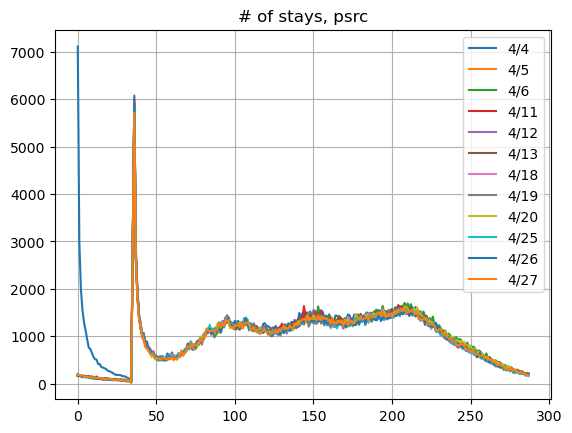

In [121]:
plt.title('# of stays, psrc')
for i in range(trip_stay_ct.shape[0]):
    plt.plot(trip_stay_ct.loc[i, 0:], label='4/'+str(trip_stay_ct.day[i]))
plt.legend()
plt.grid()

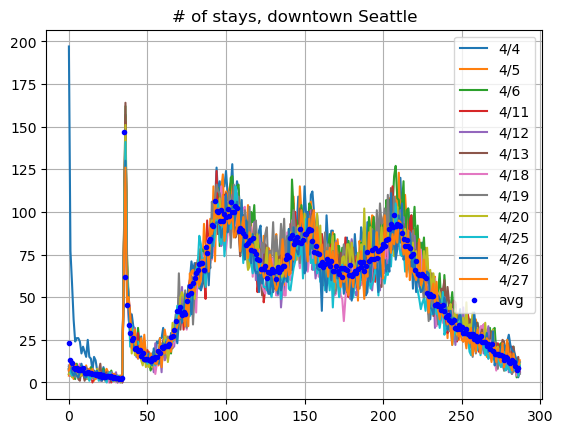

In [161]:
trip_stay_ct = trip_stay_ct.replace(np.nan, 0)
avg_val = np.sum(trip_stay_ct.loc[:, 0:].to_numpy(), axis=0)/(np.count_nonzero(trip_stay_ct.loc[:, 0:].to_numpy(), axis=0))
print('max loc', np.argmax(avg_val))
print('max value',  trip_stay_ct.loc[:, 36].values)

plt.title('# of stays, downtown Seattle')
for i in range(trip_stay_ct.shape[0]):
    plt.plot(trip_stay_ct.loc[i, 0:], label='4/'+str(trip_stay_ct.day[i]))
plt.plot(avg_val, 'b.', label='avg')
plt.legend()
plt.grid()

In [183]:
trip_stay_ct.columns

Index(['5min', 0], dtype='object')

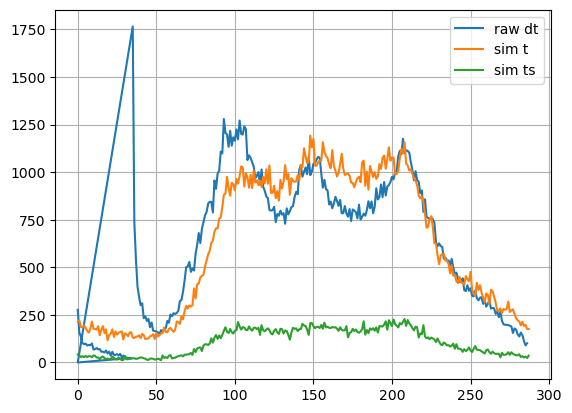

In [194]:
trip_stay_ct = trip_stay.groupby(by=['5min', 'field_1']).size().to_frame()
trip_stay_ct = trip_stay.groupby(by=['5min']).size().to_frame()
trip_stay_ct.reset_index(inplace=True)

insert_35 = pd.DataFrame([[35, 0]], columns=['5min', 0])
trip_stay_ct = pd.concat([trip_stay_ct, insert_35])
trip_stay_ct = trip_stay_ct.sort_values(by=['5min'])
plt.plot(trip_stay_ct[0], label='raw dt')

fcd_test = (fcd_dt[fcd_dt['sim_t']==1]).groupby(by=['time_5_new', 'reids']).size().to_frame()
fcd_test = fcd_test.groupby(by=['time_5_new']).size().to_frame()
plt.plot(fcd_test[0], label = 'sim t')

fcd_test = (fcd_dt[fcd_dt['sim_ts']==1]).groupby(by=['time_5_new', 'reids']).size().to_frame()
fcd_test = fcd_test.groupby(by=['time_5_new']).size().to_frame()
plt.plot(fcd_test[0], label = 'sim ts')

plt.legend()
plt.grid()

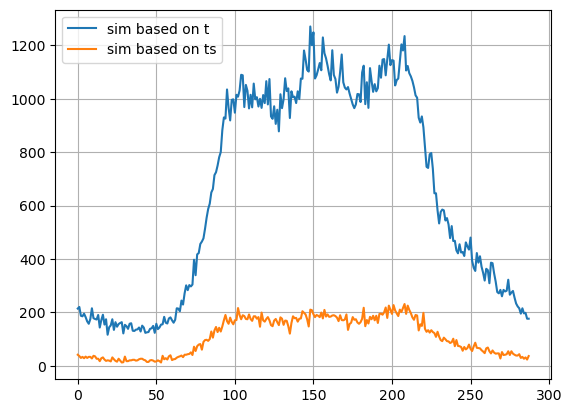

In [172]:
plt.plot(fcd_dt.groupby(by=['time_5_new']).sum()['sim_t'], label='sim based on t')
plt.plot(fcd_dt.groupby(by=['time_5_new']).sum()['sim_ts'], label='sim based on ts')
plt.legend()
plt.grid()

### NMF test

In [168]:
#!pip install implicit

In [5]:
def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def convert_timedic2mx(time_dict):
    #dataDict = {'device1':(1,1,0,1), 'device2':(0,1,0,1), 'device3':(1,0,0,1)}
    #orderedNames = ['device1','device2','device3']
    times = list(time_dict.keys())
    dataMatrix = np.array([time_dict[i] for i in times])
    return(dataMatrix)

def get_missing_rate(time_index_mx, input_mx_indi):
    indi_m = input_mx_indi[time_index_mx]
    return(np.count_nonzero(np.sum(indi_m,axis=1))/(indi_m.shape[0]))

def check_missings(fcd_dt, sim_col, time_interval, plot_idx=True):
    input_mx = getinput_mx(fcd_dt, sim_col)
    num_taz = int(input_mx.shape[1]/time_interval)
    #print('num taz', num_taz)
    time_dic = get_pred_timedict(num_taz, time_interval)
    time_mx = convert_timedic2mx(time_dic)
    missing_rate = []
    for i in range(input_mx.shape[0]):
        missing_rate.append(get_missing_rate(time_mx, input_mx[i,]))
        #print(missing_rate)
    if plot_idx == True:
        plt.hist(missing_rate)
        plt.title('hist of non-missing rate')
        plt.xlabel('non-missing rate')
        plt.ylabel('# of ids')
        print(max(missing_rate))
        print(min(missing_rate))
    return(np.array(missing_rate))

In [6]:
#fcd_dt = pd.read_csv('fcd_dt_ht_with_stay_Seadt.csv', index_col=0)
#fcd_dt = pd.read_csv('fcd_dt_all_with_stay_Seadt.csv', index_col=0)

fcd_dt = pd.read_csv('fcd_dt_ht_with_stay_Seadt.csv', index_col=0)
#fcd_dt = pd.read_csv('fcd_dt_all_with_stay_Seadt.csv', index_col=0)
fcd_dt = check_fcd_dt(fcd_dt)
fcd_dt['all'] = 1

C:\Users\flwang\AppData\Local\Temp\ipykernel_24860\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


0.13194444444444445
0.006944444444444444


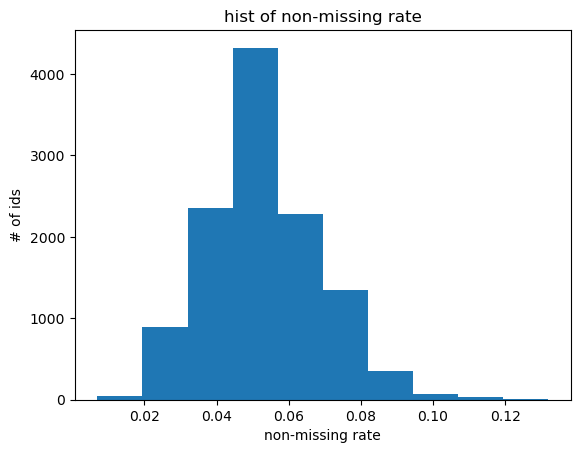

In [11]:
missing_info = check_missings(fcd_dt, 'sim_t', 288)

In [7]:
def fit_process_dt_als(sim_dt, missing_info, missing_val, k_val, reg_val, iter_val, alpha_val):
    model = implicit.als.AlternatingLeastSquares(factors=k_val, regularization=reg_val, iterations=iter_val)
    fit_dt = sim_dt[np.where(missing_info>=missing_val)[0],]
    ix = np.nonzero(fit_dt)
    sparse_fit_dt = sparse.csc_matrix((fit_dt[ix], ix))

    alpha = 15
    data = (sparse_fit_dt * alpha).astype('double')
    model.fit(data)


In [10]:
k_val = 100
reg_val=0.1
iter_val=1000
missing_val = 0.1

In [175]:
model = implicit.als.AlternatingLeastSquares(factors=k_val, regularization=reg_val, iterations=iter_val)
fit_dt = sim_dt[np.where(missing_info>=missing_val)[0],]
ix = np.nonzero(fit_dt)
sparse_fit_dt = sparse.csc_matrix((fit_dt[ix], ix))

alpha = 15
data = (sparse_fit_dt * alpha).astype('double')
model.fit(data)
recommended = model.recommend(user_id, sparse_user_item)

C:\Users\flwang\anaconda3\lib\site-packages\implicit\utils.py:33: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(
C:\Users\flwang\anaconda3\lib\site-packages\implicit\utils.py:138: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.0 seconds
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

In [156]:
fit_dt = sim_dt[np.where(missing_info>=missing_val)[0],]
ix = np.nonzero(fit_dt)
sparse_fit_dt = sparse.csc_matrix((fit_dt[ix], ix))
model = NMF(n_components=10, init='random', random_state=0).fit(sparse_fit_dt)

reconstructed = model.inverse_transform(model.transform(sparse_fit_dt))

C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Text(0.5, 0, 'with data larger than the value of non-missing rate')

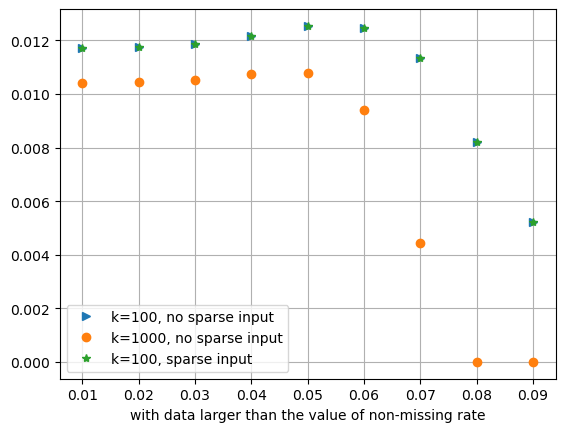

In [35]:
'''
#model fitting
rmse_sparse_100 = []
rmse_1000 = []
for i in 0.01*np.array(range(1, 10)):
    rmse_1000.append(fit_process_dt_nmf(sim_dt, missing_info, i, 1000))
    #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))

#fit_process_dt(sim_dt, missing_info, 0.05, 100)
rmse_100 = []
for i in 0.01*np.array(range(1, 10)):
    rmse_100.append(fit_process_dt_nmf(sim_dt, missing_info, i, 100)) 
    
plt.plot(0.01*np.array(range(1, 10)), rmse_100)

rmse_sparse_100 = []
for i in 0.01*np.array(range(1, 10)):
    #rmse_1000.append(fit_process_dt_nmf(sim_dt, missing_info, i, 1000))
    rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))'''
    
x_val = 0.01*np.array(range(1, 10))
rmse_100=[0.011718845062469205, 0.011733566569767748, 0.011857189689905543, 0.012175408280241933, 0.012537902574912135,
           0.012457821394958409, 0.011329832116100173, 0.008197304995008576, 0.0052040000840710594]
rmse_1000=[0.01041351437826548, 0.0104274850937627,  0.010524527034268325,  0.010755422840983998,  0.010787891532978048,
            0.009383739592580412, 0.004444300292862119, 1.9005788237971548e-06, 2.131343920457339e-09]
rmse_sparse_100=[0.011718841162099456, 0.01173356430113694, 0.011857190456366247, 0.012175403560653397, 0.012537900529530301,
                 0.012457821977194907, 0.011329854774437592, 0.008197283856768963, 0.0052039184389672385]
plt.plot(x_val, rmse_100, '>', label='k=100, no sparse input')
plt.plot(x_val, rmse_1000, 'o', label='k=1000, no sparse input')
plt.plot(x_val, rmse_sparse_100, '*', label='k=100, sparse input')
plt.legend()
plt.grid()
plt.xlabel('with data larger than the value of non-missing rate')

In [ ]:
sim_dt_all = getinput_mx(fcd_dt, 'all')

#get non zero loc in sumo simulation data
non_zero_loc = np.where(sim_dt_all>0)
missing_rate = 0.05

#conver data type from tuple to array
non_zero_loc = np.array(non_zero_loc)

#conduct missingness simulation 
#complete random - method 1
test_non_zero_loc = np.random.choice(list(range(non_zero_loc.shape[1])), 
                                     size=int((non_zero_loc.shape[1])*missing_rate))
sim_missings = non_zero_loc[:, test_non_zero_loc]

#revise the true data into sim missing data
sim_dt_all_wmiss = sim_dt_all.copy()
sim_dt_all_wmiss[tuple(sim_missings)] = 0

#missing based on cuebiq data pattern
sim_dt = getinput_mx(fcd_dt, 'sim_t')
print('missing rate, based on t',
      np.array(np.where(sim_dt>0)).shape[1]/np.array(np.where(sim_dt_all>0)).shape[1])

sim_dt = getinput_mx(fcd_dt, 'sim_ts')
print('missing rate, based on ts',
      np.array(np.where(sim_dt>0)).shape[1]/np.array(np.where(sim_dt_all>0)).shape[1])

In [7]:
#conduct missingness simulation
#based on time variation (manipulated)
'''original time = [0.18410042, 0.08786611, 0.15899582, 0.12552301, 0.12552301,
       0.09623431, 0.09205021, 0.10041841, 0.09205021, 0.11297071,
       0.07112971, 0.12552301, 0.12133891, 0.09205021, 0.09205021,
       0.09623431, 0.09205021, 0.07949791, 0.07531381, 0.07112971,
       0.05439331, 0.09623431, 0.06694561, 0.09623431, 0.06276151,
       0.06694561, 0.12552301, 0.07531381, 0.08368201, 0.09623431,
       0.10460251, 0.11297071, 0.12133891, 0.09205021, 0.11715481,
       0.08786611, 0.10041841, 0.10878661, 0.07531381, 0.10878661,
       0.09205021, 0.07112971, 0.12133891, 0.07531381, 0.05857741,
       0.05020921, 0.09205021, 0.06276151, 0.12133891, 0.11715481,
       0.09623431, 0.07112971, 0.10041841, 0.07949791, 0.07949791,
       0.08368201, 0.11715481, 0.11297071, 0.10460251, 0.14644351,
       0.12552301, 0.08786611, 0.08368201, 0.12970711, 0.13389121,
       0.09205021, 0.11715481, 0.12970711, 0.11297071, 0.22175732,
       0.22175732, 0.21338912, 0.17573222, 0.22175732, 0.23849372,
       0.27196653, 0.32635983, 0.32635983, 0.34309623, 0.34728033,
       0.30125523, 0.38075314, 0.35146444, 0.37238494, 0.38493724,
       0.35564854, 0.43514644, 0.44769874, 0.56903766, 0.51882845,
       0.55230126, 0.52301255, 0.60251046, 0.68200837, 0.64435146,
       0.68200837, 0.68619247, 0.75313808, 0.76150628, 0.71966527,
       0.84100418, 0.74058577, 0.84518828, 0.82426778, 0.74476987,
       0.79079498, 0.66945607, 0.70711297, 0.84937238, 0.78242678,
       0.70711297, 0.82008368, 0.74895397, 0.70292887, 0.70292887,
       0.78661088, 0.64016736, 0.81589958, 0.69456067, 0.68619247,
       0.68619247, 0.73640167, 0.59414226, 0.67364017, 0.64853556,
       0.68619247, 0.72384937, 0.60669456, 0.62343096, 0.73221757,
       0.72803347, 0.61506276, 0.72803347, 0.67364017, 0.66108787,
       0.56066946, 0.71548117, 0.66527197, 0.64435146, 0.74895397,
       0.76569038, 0.74058577, 0.68619247, 0.78242678, 0.74895397,
       0.79916318, 0.75313808, 0.73640167, 0.92050209, 0.89958159,
       0.88702929, 0.80753138, 0.83682008, 0.73221757, 0.76150628,
       0.76569038, 0.79497908, 0.69456067, 0.90794979, 0.73221757,
       0.76569038, 0.73640167, 0.75313808, 0.74058577, 0.64016736,
       0.84100418, 0.69456067, 0.66527197, 0.85355649, 0.70292887,
       0.78661088, 0.66108787, 0.67782427, 0.71129707, 0.66527197,
       0.75732218, 0.74058577, 0.77405858, 0.62343096, 0.62343096,
       0.77824268, 0.66527197, 0.84100418, 0.70711297, 0.78242678,
       0.76150628, 0.72803347, 0.71548117, 0.69456067, 0.79079498,
       0.61924686, 0.67364017, 0.72384937, 0.84100418, 0.80334728,
       0.76569038, 0.81171548, 0.76987448, 0.79079498, 0.88284519,
       0.82845188, 0.81589958, 0.85355649, 0.83263598, 0.77824268,
       0.87029289, 0.73640167, 1.        , 0.87029289, 0.75732218,
       0.82845188, 0.83263598, 0.87866109, 0.71548117, 0.86610879,
       0.80753138, 0.76569038, 0.56903766, 0.64853556, 0.75732218,
       0.67364017, 0.52301255, 0.50627615, 0.53138075, 0.53974895,
       0.60251046, 0.50209205, 0.48535565, 0.49790795, 0.41841004,
       0.42259414, 0.40167364, 0.37656904, 0.37656904, 0.42677824,
       0.40585774, 0.35146444, 0.33054393, 0.33054393, 0.31380753,
       0.32635983, 0.29288703, 0.27615063, 0.31380753, 0.32217573,
       0.30962343, 0.29288703, 0.31799163, 0.22175732, 0.29707113,
       0.28033473, 0.32635983, 0.29707113, 0.28870293, 0.28451883,
       0.22175732, 0.20083682, 0.26359833, 0.25941423, 0.23430962,
       0.27196653, 0.21757322, 0.20502092, 0.25104603, 0.23430962,
       0.14644351, 0.22175732, 0.12970711, 0.25104603, 0.15062762,
       0.23430962, 0.17991632, 0.17991632, 0.24267782, 0.16317992,
       0.19665272, 0.17573222, 0.21338912, 0.18410042, 0.10878661,
       0.10460251, 0.11715481, 0.12133891, 0.18410042, 0.13389121,
       0.12133891, 0.10460251, 0.10460251]'''
#current time_per = 
#time_per_manip = time_per.copy()
#time_per_manip[np.where(time_per>0.9)] = 1
#time_per_manip[np.where(time_per<0.9)] += 0.1 
time_per_manip=[0.28410042, 0.18786611, 0.25899582, 0.22552301, 0.22552301,
       0.19623431, 0.19205021, 0.20041841, 0.19205021, 0.21297071,
       0.17112971, 0.22552301, 0.22133891, 0.19205021, 0.19205021,
       0.19623431, 0.19205021, 0.17949791, 0.17531381, 0.17112971,
       0.15439331, 0.19623431, 0.16694561, 0.19623431, 0.16276151,
       0.16694561, 0.22552301, 0.17531381, 0.18368201, 0.19623431,
       0.20460251, 0.21297071, 0.22133891, 0.19205021, 0.21715481,
       0.18786611, 0.20041841, 0.20878661, 0.17531381, 0.20878661,
       0.19205021, 0.17112971, 0.22133891, 0.17531381, 0.15857741,
       0.15020921, 0.19205021, 0.16276151, 0.22133891, 0.21715481,
       0.19623431, 0.17112971, 0.20041841, 0.17949791, 0.17949791,
       0.18368201, 0.21715481, 0.21297071, 0.20460251, 0.24644351,
       0.22552301, 0.18786611, 0.18368201, 0.22970711, 0.23389121,
       0.19205021, 0.21715481, 0.22970711, 0.21297071, 0.32175732,
       0.32175732, 0.31338912, 0.27573222, 0.32175732, 0.33849372,
       0.37196653, 0.42635983, 0.42635983, 0.44309623, 0.44728033,
       0.40125523, 0.48075314, 0.45146444, 0.47238494, 0.48493724,
       0.45564854, 0.53514644, 0.54769874, 0.66903766, 0.61882845,
       0.65230126, 0.62301255, 0.70251046, 0.78200837, 0.74435146,
       0.78200837, 0.78619247, 0.85313808, 0.86150628, 0.81966527,
       0.94100418, 0.84058577, 0.94518828, 0.92426778, 0.84476987,
       0.89079498, 0.76945607, 0.80711297, 0.94937238, 0.88242678,
       0.80711297, 0.92008368, 0.84895397, 0.80292887, 0.80292887,
       0.88661088, 0.74016736, 0.91589958, 0.79456067, 0.78619247,
       0.78619247, 0.83640167, 0.69414226, 0.77364017, 0.74853556,
       0.78619247, 0.82384937, 0.70669456, 0.72343096, 0.83221757,
       0.82803347, 0.71506276, 0.82803347, 0.77364017, 0.76108787,
       0.66066946, 0.81548117, 0.76527197, 0.74435146, 0.84895397,
       0.86569038, 0.84058577, 0.78619247, 0.88242678, 0.84895397,
       0.89916318, 0.85313808, 0.83640167, 1.        , 0.99958159,
       0.98702929, 0.90753138, 0.93682008, 0.83221757, 0.86150628,
       0.86569038, 0.89497908, 0.79456067, 1.        , 0.83221757,
       0.86569038, 0.83640167, 0.85313808, 0.84058577, 0.74016736,
       0.94100418, 0.79456067, 0.76527197, 0.95355649, 0.80292887,
       0.88661088, 0.76108787, 0.77782427, 0.81129707, 0.76527197,
       0.85732218, 0.84058577, 0.87405858, 0.72343096, 0.72343096,
       0.87824268, 0.76527197, 0.94100418, 0.80711297, 0.88242678,
       0.86150628, 0.82803347, 0.81548117, 0.79456067, 0.89079498,
       0.71924686, 0.77364017, 0.82384937, 0.94100418, 0.90334728,
       0.86569038, 0.91171548, 0.86987448, 0.89079498, 0.98284519,
       0.92845188, 0.91589958, 0.95355649, 0.93263598, 0.87824268,
       0.97029289, 0.83640167, 1.        , 0.97029289, 0.85732218,
       0.92845188, 0.93263598, 0.97866109, 0.81548117, 0.96610879,
       0.90753138, 0.86569038, 0.66903766, 0.74853556, 0.85732218,
       0.77364017, 0.62301255, 0.60627615, 0.63138075, 0.63974895,
       0.70251046, 0.60209205, 0.58535565, 0.59790795, 0.51841004,
       0.52259414, 0.50167364, 0.47656904, 0.47656904, 0.52677824,
       0.50585774, 0.45146444, 0.43054393, 0.43054393, 0.41380753,
       0.42635983, 0.39288703, 0.37615063, 0.41380753, 0.42217573,
       0.40962343, 0.39288703, 0.41799163, 0.32175732, 0.39707113,
       0.38033473, 0.42635983, 0.39707113, 0.38870293, 0.38451883,
       0.32175732, 0.30083682, 0.36359833, 0.35941423, 0.33430962,
       0.37196653, 0.31757322, 0.30502092, 0.35104603, 0.33430962,
       0.24644351, 0.32175732, 0.22970711, 0.35104603, 0.25062762,
       0.33430962, 0.27991632, 0.27991632, 0.34267782, 0.26317992,
       0.29665272, 0.27573222, 0.31338912, 0.28410042, 0.20878661,
       0.20460251, 0.21715481, 0.22133891, 0.28410042, 0.23389121,
       0.22133891, 0.20460251, 0.20460251]
def get_bernoulli_sample(prob):
    return(np.random.binomial(1, prob, 1)[0])

def sim_based_t(fcd_dt, time_per, colname):
    get_time_sim = lambda x: get_bernoulli_sample(time_per[x])
    fcd_dt[colname] = fcd_dt['time_5_new'].apply(get_time_sim)
    return(fcd_dt)

fcd_dt = sim_based_t(fcd_dt, time_per_manip, 'sim_t2')

In [8]:
#prediction based on time
#prediction based on time

def fit_process_dt_mf(fcd_dt, tru_col, check_col, missing_info, missing_val, k_val, model_name): 
    #convert data into matrix
    result_para = []
    sim_dt = getinput_mx(fcd_dt, check_col)
    sim_dt_tru = getinput_mx(fcd_dt, tru_col)
    fit_dt = sim_dt[np.where(missing_info>=missing_val)[0],]
    fit_dt_tru = sim_dt_tru[np.where(missing_info>=missing_val)[0],]
    
    #predict data based on missing_rate
    if  model_name == 'NMF':
        model = NMF(n_components=k_val, init='random', random_state=0)
        W = model.fit_transform(fit_dt)
        H = model.components_

    if model_name == 'BMF':
        #some of the parameters may be reconducted
        model = nimfa.Bmf(fit_dt, seed="nndsvd", rank=k_val, max_iter=1000, lambda_w=1.1, lambda_h=1.1)
        model_fit = model()
        
        W = model_fit.fit.W
        H = model_fit.fit.H
        
    #check if the model fit the data well
   
    
    if True in np.isnan(W) or True in np.isnan(H):
        print('Error, fitting data failed')
        del(W, H)
        return([0,0,0,0])
        
    else:
        pred_dt = np.dot(W, H)
        pred_dt = np.array(pred_dt)
    
        model_rmse = mean_squared_error(fit_dt, pred_dt, squared=False)
        model_rmse_tru = mean_squared_error(fit_dt_tru, pred_dt, squared=False)

        print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val), model_rmse)
        print('RMSE with True, data with missing rate>='+str(missing_val)+', k='+str(k_val), model_rmse_tru)

        WH_max, WH_index = get_pred_dt(pred_dt, 288)
        ori_miss_per, mitigate_miss_per = check_pred_index(fit_dt, fit_dt_tru, WH_index)

        result_para = [model_rmse, model_rmse_tru, ori_miss_per, mitigate_miss_per]    

        del(W, H, pred_dt)
        return(result_para)
    

def check_pred_index(fit_dt, fit_dt_tru, WH_index):
    WH_max_tru, WH_index_tru = get_pred_dt(fit_dt, 288)
    WH_max_mis, WH_index_mis = get_pred_dt(fit_dt_tru, 288)

    #sim var vs sim true
    ori_miss_per = 1 - (np.count_nonzero(1*((WH_index_mis == WH_index_tru)==True))/(len(WH_index_mis.flatten())))
    #sim pred vs sim true
    check_idx = np.where((1*((WH_index_mis == WH_index_tru)==True))==0)
    mitigate_miss_per  = np.count_nonzero(1*(WH_index[check_idx] == WH_index_tru[check_idx]))/(len(WH_index[check_idx]))
    
    print('% of missings (sim missing vs sim true)', ori_miss_per)
    print('% of missings mitigated', mitigate_miss_per)
    return(ori_miss_per, mitigate_miss_per)
    
def fit_process_dt_nmf_csrsparse(sim_dt, missing_info, missing_val, k_val):
    fit_dt = sim_dt[np.where(missing_info>=missing_val)[0],]
    ix = np.nonzero(fit_dt)
    sparse_fit_dt = sparse.csc_matrix((fit_dt[ix], ix))
    model = NMF(n_components=k_val, init='random', random_state=0).fit(sparse_fit_dt)
    
    reconstructed = model.inverse_transform(model.transform(sparse_fit_dt))
    model_rmse = mean_squared_error(sparse_fit_dt.toarray(), reconstructed, squared=False)
    
    print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val), model_rmse)
    del(sparse_fit_dt, reconstructed)
    return(model_rmse)         
    

def fit_dtbytime(fcd_dt, sim_col, tru_col, missing_info, missing_val, time_interval, k_val, model_name):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    num_taz = len(np.unique(fcd_dt['taz_index']))
    num_time = len(np.unique(fcd_dt['time_5_new']))
    sim_dt = getinput_mx(fcd_dt, sim_col)
    sim_dt_tru = getinput_mx(fcd_dt, tru_col)
    
    #predict data based on missing_rate
    
    fit_dt = sim_dt[np.where(missing_info>=missing_val)[0],]
    fit_dt_tru = sim_dt_tru[np.where(missing_info>=missing_val)[0],]
    
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    
    null_idx = 0
    result_para = {}
    for ky in time_dict:
        result_para[ky] = []
        #print(ky)
        input_dt = fit_dt[:, time_dict[ky]]
        input_dt_tru = fit_dt_tru[:, time_dict[ky]]
        if model_name == 'NMF':
            model = NMF(n_components=k_val, init='random', random_state=0)
            W = model.fit_transform(input_dt)
            H = model.components_
            
        if model_name == 'BMF':
            #some of the parameters may be reconducted
            model = nimfa.Bmf(input_dt, seed="nndsvd", rank=k_val, max_iter=1000, lambda_w=1.1, lambda_h=1.1)
            model_fit = model()

            W = model_fit.fit.W
            H = model_fit.fit.H
        
        #pred_dt = np.dot(W, H)
        #pred_dt = np.array(pred_dt)
        
        if True in np.isnan(W) or True in np.isnan(H):
            print('Error, fitting data failed')
            null_idx = 1
            del(W, H)
            result_para[ky] = [0,0,0,0]
        
        else:
            #print(WH.shape)
            pred_dt = np.dot(W, H)
            pred_dt = np.array(pred_dt)
            
            WH_max, WH_index = get_pred_dt_time(pred_dt, num_taz)
            #print(WH_max.shape, WH_index.shape)

            model_rmse = mean_squared_error(input_dt, pred_dt, squared=False)
            model_rmse_tru = mean_squared_error(input_dt_tru, pred_dt, squared=False)

            print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val)+','+ky, model_rmse)
            print('RMSE with True, data with missing rate>='+str(missing_val)+', k='+str(k_val)+','+ky, model_rmse_tru)

            ori_miss_per, mitigate_miss_per = check_pred_indexbytime(input_dt, input_dt_tru, WH_index, num_taz)

            del(WH_max, WH_index, pred_dt)
            #pd.DataFrame(WH_max).to_csv('WH_max_'+ky+'_'+save_name+'.csv')
            #pd.DataFrame(WH_index).to_csv('WH_index'+ky+'_'+save_name+'.csv')
            result_para[ky] = [model_rmse, model_rmse_tru, ori_miss_per, mitigate_miss_per]
    
    return(result_para)
        

def check_pred_indexbytime(fit_dt, fit_dt_tru, WH_index, num_taz):
    WH_max_tru, WH_index_tru = get_pred_dt_time(fit_dt, num_taz)
    WH_max_mis, WH_index_mis = get_pred_dt_time(fit_dt_tru, num_taz)

    #sim var vs sim true
    ori_miss_per = 1 - (np.count_nonzero(1*((WH_index_mis == WH_index_tru)==True))/(len(WH_index_mis.flatten())))
    #sim pred vs sim true
    check_idx = np.where((1*((WH_index_mis == WH_index_tru)==True))==0)
    mitigate_miss_per  = np.count_nonzero(1*(WH_index[check_idx] == WH_index_tru[check_idx]))/(len(WH_index[check_idx]))
    
    print('% of missings (sim missing vs sim true)', ori_miss_per)
    print('% of missings mitigated', mitigate_miss_per)
    return(ori_miss_per, mitigate_miss_per)

def get_pred_dt_time(WH_pred, num_taz):
    #print('num taz', num_taz)
    time_interval = int(WH_pred.shape[1]/num_taz)
    pred_time_dic = get_pred_timedict(num_taz, time_interval)
    for t in pred_time_dic:
        pred_val = WH_pred[:, pred_time_dic[t]]
        if t == 0:
            max_val, max_index = get_maxvalnindex(pred_val)
        else:
            max_val_cur, max_index_cur = get_maxvalnindex(pred_val)
            max_val = np.vstack((max_val, max_val_cur))
            max_index = np.vstack((max_index, max_index_cur))
    return(max_val.T, max_index.T) 


def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def add_result2dict(result_para, result_para_time, result_para_dict):
    result_para_dict = add_val(result_para, 'ori', result_para_dict)
    result_para_dict = add_val(result_para_time['mor'], 'mor', result_para_dict)
    result_para_dict = add_val(result_para_time['noon'], 'noon', result_para_dict)
    result_para_dict = add_val(result_para_time['eve'], 'eve', result_para_dict)
    result_para_dict = add_val(result_para_time['other'], 'other', result_para_dict)
    return(result_para_dict)
    
    
def add_val(result_val, ky, result_para_dict):    
    result_para_dict[ky]['rmse_predvssim'].append(result_val[0])
    result_para_dict[ky]['rmse_predvstrue'].append(result_val[1])
    result_para_dict[ky]['per of missings (sim missing vs sim true)'].append(result_val[2])
    result_para_dict[ky]['per of missings mitigated'].append(result_val[3])
    return(result_para_dict)

#plot the results
def plot_paras(result_para_dict, xval, kval, missinginfo, ypop):
    plot_popidx = 0
    for ky in result_para_dict:
        #plt.figure(idx)
        paras = list(result_para_dict[ky].keys())
        #print(paras)
        #fig.tight_layout()
        
        plt.title('model:k='+str(kval)+', use '+missinginfo)
        #ax[0].set_title('RMSE')
        #print(result_para_dict[ky][paras[0]])
        plt.figure(1)
        plt.plot(xval, result_para_dict[ky][paras[0]], label=ky)
        plt.grid()
        plt.xlabel('data > non-missing rate')
        plt.ylabel('RMSE, sim vs pred')
        #ax[0, 0].legend()
        plt.legend()
        
        plt.figure(2)
        plt.plot(xval, result_para_dict[ky][paras[1]], label=ky)
        plt.grid()
        plt.xlabel('data > non-missing rate')
        plt.ylabel('RMSE, sim true vs pred')
        #ax[0, 1].legend()
        plt.legend()
        
        plt.figure(3)
        plt.plot(xval, result_para_dict[ky][paras[2]], label=ky)
        plt.grid()
        plt.xlabel('data > non-missing rate')
        plt.ylabel(paras[2])
        plt.legend()
        
        plt.figure(4)
        plt.plot(xval, result_para_dict[ky][paras[3]], label=ky)
        plt.grid()
        plt.xlabel('data > non-missing rate')
        plt.ylabel(paras[3])
        #label = f"({x},{y})"
        plt.legend()
        if plot_popidx == 0:
            for i in range(len(xval)):
                label =  f"{ypop[i]}"

                plt.annotate(label, # this is the text
                             (xval[i], 0.015), # these are the coordinates to position the label
                             textcoords="offset points", # how to position the text
                             xytext=(0,10), # distance from text to points (x,y)
                             ha='center') # horizontal alignment can be left, right or center
            plot_popidx = 1

            
            
        
def save_result_dict(result_dict, savename):
    # create json object from dictionary
    #json = json.dumps(result_dict)
    # open file for writing, "w" 
    f = open(savename,"w")
    # write json object to file
    f.write(str(result_dict))
    # close file
    f.close()

In [49]:
#fit_process_dt_nmf(fcd_dt, 'all', 'sim_t', missing_info, 0.09, 10)
#fit_dtbytime(fcd_dt, 'sim_t', 'all', missing_info, 0.09, 12, 10)

In [9]:
result_para_dict = {'ori':{'rmse_predvssim':[],
                     'rmse_predvstrue':[],
                     'per of missings (sim missing vs sim true)':[],
                     'per of missings mitigated':[]},
              'mor':{'rmse_predvssim':[],
                     'rmse_predvstrue':[],
                     'per of missings (sim missing vs sim true)':[],
                     'per of missings mitigated':[]},
               'noon':{'rmse_predvssim':[],
                     'rmse_predvstrue':[],
                     'per of missings (sim missing vs sim true)':[],
                     'per of missings mitigated':[]},
               'eve':{'rmse_predvssim':[],
                     'rmse_predvstrue':[],
                     'per of missings (sim missing vs sim true)':[],
                     'per of missings mitigated':[]},
               'other':{'rmse_predvssim':[],
                     'rmse_predvstrue':[],
                     'per of missings (sim missing vs sim true)':[],
                     'per of missings mitigated':[]}
              }

In [10]:
def fit_model_get_para(fcd_dt, check_col, k_val, x_val, time_interval, result_para_dict, model_name):
    missing_info = check_missings(fcd_dt, check_col, time_interval, False)
    result_para_dict_return = copy.deepcopy(result_para_dict)
    for i in x_val:
        result_para = fit_process_dt_mf(fcd_dt, 'all', check_col, missing_info, i, k_val, model_name)
        result_para_time = fit_dtbytime(fcd_dt, check_col, 'all', missing_info, i, 12, k_val, model_name)
        result_para_dict_return = add_result2dict(result_para, result_para_time, result_para_dict_return)
        #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))
    return(result_para_dict_return)

In [55]:
#sim_dt = getinput_mx(fcd_dt, 'sim_t')
#sim_dt = sim_dt[np.where(missing_info>=0.01)[0],]

In [11]:
x_val_simt = 0.01*np.array(range(1, 10))
result_para_dict_simt_bmf_100 = fit_model_get_para(fcd_dt, 'sim_t', 100, x_val_simt, 288, result_para_dict, 'BMF')
result_para_dict_simt_nmf_100 = fit_model_get_para(fcd_dt, 'sim_t', 100, x_val_simt, 288, result_para_dict, 'NMF')

C:\Users\flwang\AppData\Local\Temp\ipykernel_16512\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.01, k=100 0.011908795749803816
RMSE with True, data with missing rate>=0.01, k=100 0.057898308775880696
% of missings (sim missing vs sim true) 0.9473901679100936
% of missings mitigated 0.0


C:\Users\flwang\AppData\Local\Temp\ipykernel_16512\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.01, k=100,mor 0.013968226787340911
RMSE with True, data with missing rate>=0.01, k=100,mor 0.06175690345610276
% of missings (sim missing vs sim true) 0.9419291151736052
% of missings mitigated 0.0
RMSE, data with missing rate>=0.01, k=100,noon 0.01869821728944144
RMSE with True, data with missing rate>=0.01, k=100,noon 0.0671686990400423
% of missings (sim missing vs sim true) 0.9194973019534142
% of missings mitigated 0.0
RMSE, data with missing rate>=0.01, k=100,eve 0.014808702081777078
RMSE with True, data with missing rate>=0.01, k=100,eve 0.06165165131885965
% of missings (sim missing vs sim true) 0.9361450782260623
% of missings mitigated 0.0
RMSE, data with missing rate>=0.01, k=100,other 0.005070023831853662
RMSE with True, data with missing rate>=0.01, k=100,other 0.048312685661882224
% of missings (sim missing vs sim true) 0.9743975329455968
% of missings mitigated 0.0


C:\Users\flwang\AppData\Local\Temp\ipykernel_16512\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\nimfa\methods\seeding\nndsvd.py:89: RuntimeWarning: invalid value encountered in double_scalars
  self.W[:, i] = sqrt(S[i] * termp) / n_uup * uup
C:\Users\flwang\anaconda3\lib\site-packages\nimfa\methods\seeding\nndsvd.py:90: RuntimeWarning: invalid value encountered in double_scalars
  self.H[i, :] = sqrt(S[i] * termp) / n_vvp * vvp.T
C:\Users\flwang\anaconda3\lib\site-packages\nimfa\methods\seeding\nndsvd.py:89: RuntimeWarning: invalid value encountered in double_scalars
  self.W[:, i] = sqrt(S[i] * termp) / n_uup * uup
C:\Users\flw

C:\Users\flwang\anaconda3\lib\site-packages\nimfa\methods\seeding\nndsvd.py:89: RuntimeWarning: invalid value encountered in double_scalars
  self.W[:, i] = sqrt(S[i] * termp) / n_uup * uup
C:\Users\flwang\anaconda3\lib\site-packages\nimfa\methods\seeding\nndsvd.py:90: RuntimeWarning: invalid value encountered in double_scalars
  self.H[i, :] = sqrt(S[i] * termp) / n_vvp * vvp.T
C:\Users\flwang\anaconda3\lib\site-packages\nimfa\methods\seeding\nndsvd.py:89: RuntimeWarning: invalid value encountered in double_scalars
  self.W[:, i] = sqrt(S[i] * termp) / n_uup * uup
C:\Users\flwang\anaconda3\lib\site-packages\nimfa\methods\seeding\nndsvd.py:90: RuntimeWarning: invalid value encountered in double_scalars
  self.H[i, :] = sqrt(S[i] * termp) / n_vvp * vvp.T
C:\Users\flwang\anaconda3\lib\site-packages\nimfa\methods\seeding\nndsvd.py:89: RuntimeWarning: invalid value encountered in double_scalars
  self.W[:, i] = sqrt(S[i] * termp) / n_uup * uup
C:\Users\flwang\anaconda3\lib\site-packages\ni

MemoryError: Unable to allocate 4.35 GiB for an array with shape (11664, 50112) and data type float64

In [ ]:
x_val_simt2 = (0.02*np.array(range(22, 32)))+0.01
result_para_dict_simt2_bmf_100 = fit_model_get_para(fcd_dt, 'sim_t2', 100, x_val_simt2, 288, result_para_dict, 'BMF')

In [ ]:
x_val_simt = 0.01*np.array(range(1, 10))
#result_para_dict_simt = fit_model_get_para(fcd_dt, 'sim_t', 10, x_val_simt, 288, result_para_dict, 'BMF')
#result_para_dict_simt_100 = fit_model_get_para(fcd_dt, 'sim_t', 100, x_val_simt, 288, result_para_dict, 'BMF')
k_val = 100
result_para_dict_simt_100_bmf = copy.deepcopy(result_para_dict)
for i in x_val_simt:
    result_para = fit_process_dt_nmf(fcd_dt, 'all', 'sim_t', missing_info, i, k_val, 'BMF')
    result_para_time = fit_dtbytime(fcd_dt, 'sim_t', 'all', missing_info, i, 12, k_val, 'BMF')
    result_para_dict_simt_100_bmf = add_result2dict(result_para, result_para_time, result_para_dict_simt_100_bmf)
    #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100)  

In [47]:
missing_info = check_missings(fcd_dt, 'sim_t', 288, False)
k_val = 10
result_para_dict_simt = copy.deepcopy(result_para_dict)
for i in 0.01*np.array(range(1, 10)):
    result_para = fit_process_dt_nmf(fcd_dt, 'all', 'sim_t', missing_info, i, k_val, 'NMF')
    result_para_time = fit_dtbytime(fcd_dt, 'sim_t', 'all', missing_info, i, 12, k_val, 'NMF')
    result_para_dict_simt = add_result2dict(result_para, result_para_time, result_para_dict_simt)
    #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))
    

k_val = 100
result_para_dict_simt_100 = copy.deepcopy(result_para_dict)
for i in 0.01*np.array(range(1, 10)):
    result_para = fit_process_dt_nmf(fcd_dt, 'all', 'sim_t', missing_info, i, k_val, 'NMF')
    result_para_time = fit_dtbytime(fcd_dt, 'sim_t', 'all', missing_info, i, 12, k_val, 'NMF')
    result_para_dict_simt_100 = add_result2dict(result_para, result_para_time, result_para_dict_simt_100)
    #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100)   


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.01, k=10 0.011861481770917106
RMSE with True, data with missing rate>=0.01, k=10 0.057591293538391555
% of missings (sim missing vs sim true) 0.9473901679100936
% of missings mitigated 0.00036099353686940016


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=10,mor 0.013859302799877782
RMSE with True, data with missing rate>=0.01, k=10,mor 0.061409481654068586
% of missings (sim missing vs sim true) 0.9419291151736052
% of missings mitigated 0.1439850457495264
RMSE, data with missing rate>=0.01, k=10,noon 0.018599294114145782
RMSE with True, data with missing rate>=0.01, k=10,noon 0.06663463440471604
% of missings (sim missing vs sim true) 0.9194973019534142
% of missings mitigated 0.0006290470711084486


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=10,eve 0.014686795660785661
RMSE with True, data with missing rate>=0.01, k=10,eve 0.06131457613238765
% of missings (sim missing vs sim true) 0.9361450782260623
% of missings mitigated 0.12332745836244746
RMSE, data with missing rate>=0.01, k=10,other 0.0050391726058245725
RMSE with True, data with missing rate>=0.01, k=10,other 0.04817776021159453
% of missings (sim missing vs sim true) 0.9743975329455968
% of missings mitigated 0.0866651885793117


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.02, k=10 0.011877536296354201
RMSE with True, data with missing rate>=0.02, k=10 0.05761897340150735
% of missings (sim missing vs sim true) 0.9472590758840116
% of missings mitigated 0.00036045797961888244


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.02, k=10,mor 0.01388070242604708
RMSE with True, data with missing rate>=0.02, k=10,mor 0.06145347607074007
% of missings (sim missing vs sim true) 0.941791457094955
% of missings mitigated 0.14271409136655355
RMSE, data with missing rate>=0.02, k=10,noon 0.018625756960884653
RMSE with True, data with missing rate>=0.02, k=10,noon 0.06666683229718667
% of missings (sim missing vs sim true) 0.919286908436214
% of missings mitigated 0.00034875836194317667


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.02, k=10,eve 0.014703299983863547
RMSE with True, data with missing rate>=0.02, k=10,eve 0.06126603262672687
% of missings (sim missing vs sim true) 0.9359861845972957
% of missings mitigated 0.12121997241610334
RMSE, data with missing rate>=0.02, k=10,other 0.00504378203699889
RMSE with True, data with missing rate>=0.02, k=10,other 0.04820066095892989
% of missings (sim missing vs sim true) 0.974339353127232
% of missings mitigated 0.08601381107795056


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.03, k=10 0.012001591648297517
RMSE with True, data with missing rate>=0.03, k=10 0.057746840221452135
% of missings (sim missing vs sim true) 0.946319543721706
% of missings mitigated 0.00036554165076642446


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.03, k=10,mor 0.014012703450132393
RMSE with True, data with missing rate>=0.03, k=10,mor 0.061559866704815516
% of missings (sim missing vs sim true) 0.9407736676991502
% of missings mitigated 0.12791749879303205
RMSE, data with missing rate>=0.03, k=10,noon 0.018830281157937768
RMSE with True, data with missing rate>=0.03, k=10,noon 0.06681604334763545
% of missings (sim missing vs sim true) 0.9177500297831784
% of missings mitigated 0.00016226193132263758


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.03, k=10,eve 0.014880110096300274
RMSE with True, data with missing rate>=0.03, k=10,eve 0.06145329045786582
% of missings (sim missing vs sim true) 0.9348080261411212
% of missings mitigated 0.11237004448595374
RMSE, data with missing rate>=0.03, k=10,other 0.005085500808195335
RMSE with True, data with missing rate>=0.03, k=10,other 0.048298424827468475
% of missings (sim missing vs sim true) 0.9739660560376656
% of missings mitigated 0.07757608932990441


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.04, k=10 0.012333412474008829
RMSE with True, data with missing rate>=0.04, k=10 0.05806906215263047
% of missings (sim missing vs sim true) 0.9432730700318003
% of missings mitigated 0.0003199875464306254


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=10,mor 0.014389104925496029
RMSE with True, data with missing rate>=0.04, k=10,mor 0.0619822568105651
% of missings (sim missing vs sim true) 0.9372626845127913
% of missings mitigated 0.11620325679289772


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=10,noon 0.01943439020966053
RMSE with True, data with missing rate>=0.04, k=10,noon 0.06729071592148717
% of missings (sim missing vs sim true) 0.9129778940623665
% of missings mitigated 9.503896597605019e-05


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=10,eve 0.015310394182962388
RMSE with True, data with missing rate>=0.04, k=10,eve 0.06191236456627443
% of missings (sim missing vs sim true) 0.9312137670104351
% of missings mitigated 0.09430005635722617


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=10,other 0.005156913382794126
RMSE with True, data with missing rate>=0.04, k=10,other 0.048426473670651636
% of missings (sim missing vs sim true) 0.9725853541433519
% of missings mitigated 0.09505327673228782


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, k=10 0.012729749571966173
RMSE with True, data with missing rate>=0.05, k=10 0.05880726664682562
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.000742306085790553


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, k=10,mor 0.01479752473155533
RMSE with True, data with missing rate>=0.05, k=10,mor 0.06272493392831388
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07883742570120968


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, k=10,noon 0.020230021374531098
RMSE with True, data with missing rate>=0.05, k=10,noon 0.06840617573166134
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.00025826966650242426
RMSE, data with missing rate>=0.05, k=10,eve 0.015899886455230366
RMSE with True, data with missing rate>=0.05, k=10,eve 0.06312067571611471
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06590716967778718
RMSE, data with missing rate>=0.05, k=10,other 0.005172363428812574
RMSE with True, data with missing rate>=0.05, k=10,other 0.04871799070733817
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.0469656941988261


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.06, k=10 0.012770963765824813
RMSE with True, data with missing rate>=0.06, k=10 0.059887635174768555
% of missings (sim missing vs sim true) 0.931887830937642
% of missings mitigated 0.0005793668013440371


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.06, k=10,mor 0.014895481608422963
RMSE with True, data with missing rate>=0.06, k=10,mor 0.06409554392871193
% of missings (sim missing vs sim true) 0.9237925366348407
% of missings mitigated 0.05994926932687211
RMSE, data with missing rate>=0.06, k=10,noon 0.0205370567774557
RMSE with True, data with missing rate>=0.06, k=10,noon 0.06980675343678953
% of missings (sim missing vs sim true) 0.8961185867170286
% of missings mitigated 0.0003292976082017058
RMSE, data with missing rate>=0.06, k=10,eve 0.016107691438151106
RMSE with True, data with missing rate>=0.06, k=10,eve 0.06497919622359812
% of missings (sim missing vs sim true) 0.9171275686856424
% of missings mitigated 0.051363012355363794


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.06, k=10,other 0.004933129317534506
RMSE with True, data with missing rate>=0.06, k=10,other 0.04922779459510219
% of missings (sim missing vs sim true) 0.9669447501021027
% of missings mitigated 0.03289661295095639


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.07, k=10 0.011992614263893142
RMSE with True, data with missing rate>=0.07, k=10 0.060584920113530394
% of missings (sim missing vs sim true) 0.9254866740358634
% of missings mitigated 0.0018053885179502066


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.07, k=10,mor 0.014056608880928344
RMSE with True, data with missing rate>=0.07, k=10,mor 0.06534559487715583
% of missings (sim missing vs sim true) 0.9157455170719725
% of missings mitigated 0.04611498569384836
RMSE, data with missing rate>=0.07, k=10,noon 0.019494547469498524
RMSE with True, data with missing rate>=0.07, k=10,noon 0.0716626726709641
% of missings (sim missing vs sim true) 0.8877118644067796
% of missings mitigated 0.0009511950468679741


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.07, k=10,eve 0.015438681984233605
RMSE with True, data with missing rate>=0.07, k=10,eve 0.06717567682473358
% of missings (sim missing vs sim true) 0.909801031687546
% of missings mitigated 0.038948415912614845
RMSE, data with missing rate>=0.07, k=10,other 0.004321308784059673
RMSE with True, data with missing rate>=0.07, k=10,other 0.04847803607771668
% of missings (sim missing vs sim true) 0.9628921356663033
% of missings mitigated 0.029221272074077823


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.08, k=10 0.009650150431630694
RMSE with True, data with missing rate>=0.08, k=10 0.05677436238546328
% of missings (sim missing vs sim true) 0.9182703625235404
% of missings mitigated 0.007714738916571868


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.08, k=10,mor 0.010688582884434163
RMSE with True, data with missing rate>=0.08, k=10,mor 0.060358234150394596
% of missings (sim missing vs sim true) 0.9111935028248588
% of missings mitigated 0.05916166117677453
RMSE, data with missing rate>=0.08, k=10,noon 0.015948706624935666
RMSE with True, data with missing rate>=0.08, k=10,noon 0.06970939212550449
% of missings (sim missing vs sim true) 0.8773172669491526
% of missings mitigated 0.006716474228360123
RMSE, data with missing rate>=0.08, k=10,eve 0.012885753461279553
RMSE with True, data with missing rate>=0.08, k=10,eve 0.06537460640518673
% of missings (sim missing vs sim true) 0.8980024213075061
% of missings mitigated 0.023255813953488372
RMSE, data with missing rate>=0.08, k=10,other 0.003116114595040795
RMSE with True, data with missing rate>=0.08, k=10,other 0.042936930492251904
% of missings (sim missing vs sim true) 0.9587302143157305
% of missings mitigated 0.13260889416491645


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.09, k=10 0.007690334758278416
RMSE with True, data with missing rate>=0.09, k=10 0.051016427193137544
% of missings (sim missing vs sim true) 0.911108193277311
% of missings mitigated 0.02562008614753967


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.09, k=10,mor 0.007828231347560718
RMSE with True, data with missing rate>=0.09, k=10,mor 0.053418281987026695
% of missings (sim missing vs sim true) 0.9082633053221288
% of missings mitigated 0.14006682086867128


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.09, k=10,noon 0.012727082029697806
RMSE with True, data with missing rate>=0.09, k=10,noon 0.06397895272199196
% of missings (sim missing vs sim true) 0.8701855742296919
% of missings mitigated 0.011920329946685444
RMSE, data with missing rate>=0.09, k=10,eve 0.010502100208879794
RMSE with True, data with missing rate>=0.09, k=10,eve 0.059767333535504445
% of missings (sim missing vs sim true) 0.888235294117647
% of missings mitigated 0.035139883768076766


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.09, k=10,other 0.00238980846981346
RMSE with True, data with missing rate>=0.09, k=10,other 0.0372070395469539
% of missings (sim missing vs sim true) 0.951038266546288
% of missings mitigated 0.27643493500803273


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=100 0.011718845062469205
RMSE with True, data with missing rate>=0.01, k=100 0.05742133942388645
% of missings (sim missing vs sim true) 0.9473901679100936
% of missings mitigated 0.0018350243881973586


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=100,mor 0.012943196577740271
RMSE with True, data with missing rate>=0.01, k=100,mor 0.06139424374519242
% of missings (sim missing vs sim true) 0.9419291151736052
% of missings mitigated 0.14339554194042484


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=100,noon 0.018247480696655702
RMSE with True, data with missing rate>=0.01, k=100,noon 0.06634585496873031
% of missings (sim missing vs sim true) 0.9194973019534142
% of missings mitigated 0.0028249052316393257


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=100,eve 0.013676315064261806
RMSE with True, data with missing rate>=0.01, k=100,eve 0.061271522966663716
% of missings (sim missing vs sim true) 0.9361450782260623
% of missings mitigated 0.1243234223617383


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=100,other 0.004810967024234538
RMSE with True, data with missing rate>=0.01, k=100,other 0.048168615439306096
% of missings (sim missing vs sim true) 0.9743975329455968
% of missings mitigated 0.11693192538267247


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.02, k=100 0.011733566569767748
RMSE with True, data with missing rate>=0.02, k=100 0.05744962395342661
% of missings (sim missing vs sim true) 0.9472590758840116
% of missings mitigated 0.0018887118199733947


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.02, k=100,mor 0.012964622958688716
RMSE with True, data with missing rate>=0.02, k=100,mor 0.06143577672558209
% of missings (sim missing vs sim true) 0.941791457094955
% of missings mitigated 0.1421249070707173


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.02, k=100,noon 0.01827392259203088
RMSE with True, data with missing rate>=0.02, k=100,noon 0.06637771509463157
% of missings (sim missing vs sim true) 0.919286908436214
% of missings mitigated 0.002607430204611382
RMSE, data with missing rate>=0.02, k=100,eve 0.013700908948636592
RMSE with True, data with missing rate>=0.02, k=100,eve 0.06128546629518019
% of missings (sim missing vs sim true) 0.9359861845972957
% of missings mitigated 0.12117024812421652


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.02, k=100,other 0.004815628678019117
RMSE with True, data with missing rate>=0.02, k=100,other 0.04819144758270118
% of missings (sim missing vs sim true) 0.974339353127232
% of missings mitigated 0.11566341460576761


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.03, k=100 0.011857189689905543
RMSE with True, data with missing rate>=0.03, k=100 0.057585196976337294
% of missings (sim missing vs sim true) 0.946319543721706
% of missings mitigated 0.0019217983468993545


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.03, k=100,mor 0.013091975124042513
RMSE with True, data with missing rate>=0.03, k=100,mor 0.061566936034890274
% of missings (sim missing vs sim true) 0.9407736676991502
% of missings mitigated 0.13432827945727333


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.03, k=100,noon 0.018472161225652914
RMSE with True, data with missing rate>=0.03, k=100,noon 0.06652067168402429
% of missings (sim missing vs sim true) 0.9177500297831784
% of missings mitigated 0.002539399225199278
RMSE, data with missing rate>=0.03, k=100,eve 0.013879608477173365
RMSE with True, data with missing rate>=0.03, k=100,eve 0.06147088566450972
% of missings (sim missing vs sim true) 0.9348080261411212
% of missings mitigated 0.10448600836193925


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.03, k=100,other 0.0048549057757592455
RMSE with True, data with missing rate>=0.03, k=100,other 0.04828926300943124
% of missings (sim missing vs sim true) 0.9739660560376656
% of missings mitigated 0.1072021022368868


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=100 0.012175408280241933
RMSE with True, data with missing rate>=0.04, k=100 0.057885257080326914
% of missings (sim missing vs sim true) 0.9432730700318003
% of missings mitigated 0.0021683676979254666


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.04, k=100,mor 0.013454469391263654
RMSE with True, data with missing rate>=0.04, k=100,mor 0.06195752304479292
% of missings (sim missing vs sim true) 0.9372626845127913
% of missings mitigated 0.11162349068696492


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=100,noon 0.019053665125387184
RMSE with True, data with missing rate>=0.04, k=100,noon 0.06694953571832818
% of missings (sim missing vs sim true) 0.9129778940623665
% of missings mitigated 0.0026903338060912667


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=100,eve 0.014277790834191059
RMSE with True, data with missing rate>=0.04, k=100,eve 0.06193061209542259
% of missings (sim missing vs sim true) 0.9312137670104351
% of missings mitigated 0.09655106882134759


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=100,other 0.0049219933587330116
RMSE with True, data with missing rate>=0.04, k=100,other 0.04841361978202191
% of missings (sim missing vs sim true) 0.9725853541433519
% of missings mitigated 0.07768275706862726


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, k=100 0.012537902574912135
RMSE with True, data with missing rate>=0.05, k=100 0.05853086733659989
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.002722967244860267


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, k=100,mor 0.013843213028521144
RMSE with True, data with missing rate>=0.05, k=100,mor 0.06260554479826538
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08240756565829203


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, k=100,noon 0.01977246559190874
RMSE with True, data with missing rate>=0.05, k=100,noon 0.06780792098408596
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0034124566574043717
RMSE, data with missing rate>=0.05, k=100,eve 0.014843101059781693
RMSE with True, data with missing rate>=0.05, k=100,eve 0.06306572448088565
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.07208013053649714


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, k=100,other 0.004927446588611469
RMSE with True, data with missing rate>=0.05, k=100,other 0.04869171920371929
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.06319910817936228


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.06, k=100 0.012457821394958409
RMSE with True, data with missing rate>=0.06, k=100 0.0595330527865058
% of missings (sim missing vs sim true) 0.931887830937642
% of missings mitigated 0.005392567920202192


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.06, k=100,mor 0.013861891523689846
RMSE with True, data with missing rate>=0.06, k=100,mor 0.06382172910693823
% of missings (sim missing vs sim true) 0.9237925366348407
% of missings mitigated 0.0730010600439161


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.06, k=100,noon 0.019858375829254395
RMSE with True, data with missing rate>=0.06, k=100,noon 0.06907508500548713
% of missings (sim missing vs sim true) 0.8961185867170286
% of missings mitigated 0.006904273185295764
RMSE, data with missing rate>=0.06, k=100,eve 0.01493134470726502
RMSE with True, data with missing rate>=0.06, k=100,eve 0.06472994054673181
% of missings (sim missing vs sim true) 0.9171275686856424
% of missings mitigated 0.06187487742694646


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.06, k=100,other 0.004648387867537759
RMSE with True, data with missing rate>=0.06, k=100,other 0.04916312707495369
% of missings (sim missing vs sim true) 0.9669447501021027
% of missings mitigated 0.07726991471846331


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.07, k=100 0.011329832116100173
RMSE with True, data with missing rate>=0.07, k=100 0.060100909144346355
% of missings (sim missing vs sim true) 0.9254866740358634
% of missings mitigated 0.013320615435657114


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.07, k=100,mor 0.012410904154695694
RMSE with True, data with missing rate>=0.07, k=100,mor 0.0645911127635084
% of missings (sim missing vs sim true) 0.9157455170719725
% of missings mitigated 0.078616773962804


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.07, k=100,noon 0.018134310841257557
RMSE with True, data with missing rate>=0.07, k=100,noon 0.07069427111459081
% of missings (sim missing vs sim true) 0.8877118644067796
% of missings mitigated 0.012988136003597247
RMSE, data with missing rate>=0.07, k=100,eve 0.013577201540000822
RMSE with True, data with missing rate>=0.07, k=100,eve 0.06630736467714958
% of missings (sim missing vs sim true) 0.909801031687546
% of missings mitigated 0.061951817824165145


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.07, k=100,other 0.003874158098419388
RMSE with True, data with missing rate>=0.07, k=100,other 0.0482881463237679
% of missings (sim missing vs sim true) 0.9628921356663033
% of missings mitigated 0.1945744573192329


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.08, k=100 0.008197304995008576
RMSE with True, data with missing rate>=0.08, k=100 0.05592133829779657
% of missings (sim missing vs sim true) 0.9182703625235404
% of missings mitigated 0.04322817361767581


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.08, k=100,mor 0.007526928160644816
RMSE with True, data with missing rate>=0.08, k=100,mor 0.05876000001163887
% of missings (sim missing vs sim true) 0.9111935028248588
% of missings mitigated 0.14163921720596784


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.08, k=100,noon 0.012925001583698473
RMSE with True, data with missing rate>=0.08, k=100,noon 0.06780630419430676
% of missings (sim missing vs sim true) 0.8773172669491526
% of missings mitigated 0.03134354639901391
RMSE, data with missing rate>=0.08, k=100,eve 0.008987527177881508
RMSE with True, data with missing rate>=0.08, k=100,eve 0.0633000693530829
% of missings (sim missing vs sim true) 0.8980024213075061
% of missings mitigated 0.09908998988877654
RMSE, data with missing rate>=0.08, k=100,other 0.0021772026684106346
RMSE with True, data with missing rate>=0.08, k=100,other 0.04252596224841436
% of missings (sim missing vs sim true) 0.9587302143157305
% of missings mitigated 0.36794813259063097


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.09, k=100 0.0052040000840710594
RMSE with True, data with missing rate>=0.09, k=100 0.04946726894450069
% of missings (sim missing vs sim true) 0.911108193277311
% of missings mitigated 0.15333621559302493


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.09, k=100,mor 0.003561714003103202
RMSE with True, data with missing rate>=0.09, k=100,mor 0.051049659553870363
% of missings (sim missing vs sim true) 0.9082633053221288
% of missings mitigated 0.34425597532767926


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.09, k=100,noon 0.007725539465128526
RMSE with True, data with missing rate>=0.09, k=100,noon 0.06101082775451818
% of missings (sim missing vs sim true) 0.8701855742296919
% of missings mitigated 0.08927673272306609
RMSE, data with missing rate>=0.09, k=100,eve 0.004564356091072934
RMSE with True, data with missing rate>=0.09, k=100,eve 0.05647657692901584
% of missings (sim missing vs sim true) 0.888235294117647
% of missings mitigated 0.19164751993512638
RMSE, data with missing rate>=0.09, k=100,other 0.001107215084676042
RMSE with True, data with missing rate>=0.09, k=100,other 0.03666044604774989
% of missings (sim missing vs sim true) 0.951038266546288
% of missings mitigated 0.5815320578355484


In [73]:
ypop_simt = []
for i in x_val_simt:
    ypop_simt.append(len(np.where(missing_info>=i)[0]))
    
ypop_simt2 =[]    
for i in x_val:
    ypop_simt2.append(len(np.where(missing_info_simt2>=i)[0]))

C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


0.13194444444444445
0.006944444444444444
0.6631944444444444
0.4513888888888889


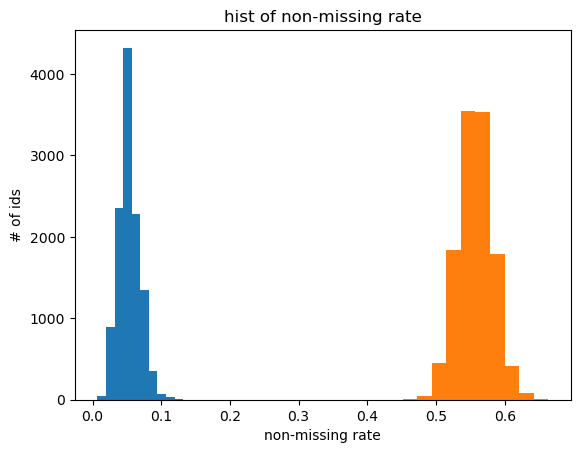

In [69]:
missing_info = check_missings(fcd_dt, 'sim_t', 288)
missing_info_simt2 = check_missings(fcd_dt, 'sim_t2', 288)

In [37]:
x_val_simt2 = (0.02*np.array(range(22, 32)))+0.01

In [39]:
missing_info = check_missings(fcd_dt, 'sim_t2', 288, False)
k_val = 10
result_para_dict_simt2 = copy.deepcopy(result_para_dict)
for i in x_val:
    result_para = fit_process_dt_nmf(fcd_dt, 'all', 'sim_t2', missing_info, i, k_val, 'NMF')
    result_para_time = fit_dtbytime(fcd_dt, 'sim_t2', 'all', missing_info, i, 12, k_val, 'NMF')
    result_para_dict_simt2 = add_result2dict(result_para, result_para_time, result_para_dict_simt2)
    #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))'''
    
k_val = 100
result_para_dict_simt2_100 = copy.deepcopy(result_para_dict)
for i in x_val:
    result_para = fit_process_dt_nmf(fcd_dt, 'all', 'sim_t2', missing_info, i, k_val, 'NMF')
    result_para_time = fit_dtbytime(fcd_dt, 'sim_t2', 'all', missing_info, i, 12, k_val, 'NMF')
    result_para_dict_simt2_100 = add_result2dict(result_para, result_para_time, result_para_dict_simt2_100)
    #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))

C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.45, k=10 0.04111722559182743
RMSE with True, data with missing rate>=0.45, k=10 0.054303558364962645
% of missings (sim missing vs sim true) 0.44363132348336043
% of missings mitigated 3.0080012834138808e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.45, k=10,mor 0.04603721382201868
RMSE with True, data with missing rate>=0.45, k=10,mor 0.05538060840320619
% of missings (sim missing vs sim true) 0.3595358745883983
% of missings mitigated 7.258186904911154e-05
RMSE, data with missing rate>=0.45, k=10,noon 0.05771167886871295
RMSE with True, data with missing rate>=0.45, k=10,noon 0.06161263580970071
% of missings (sim missing vs sim true) 0.1568745196003074
% of missings mitigated 6.805151499685262e-05
RMSE, data with missing rate>=0.45, k=10,eve 0.04767238939154101
RMSE with True, data with missing rate>=0.45, k=10,eve 0.05491400228645466
% of missings (sim missing vs sim true) 0.2982492100093945
% of missings mitigated 0.0001227224753941437
RMSE, data with missing rate>=0.45, k=10,other 0.023304530100790068
RMSE with True, data with missing rate>=0.45, k=10,other 0.04569884888139243
% of missings (sim missing vs sim true) 0.73821366484353
% of missings mitigated 0.0


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.47000000000000003, k=10 0.04111639877003737
RMSE with True, data with missing rate>=0.47000000000000003, k=10 0.05429885145621064
% of missings (sim missing vs sim true) 0.44359871137690443
% of missings mitigated 3.0092504358397714e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.47000000000000003, k=10,mor 0.04603781584016959
RMSE with True, data with missing rate>=0.47000000000000003, k=10,mor 0.0553781340911575
% of missings (sim missing vs sim true) 0.3594902463334757
% of missings mitigated 7.261588835637237e-05
RMSE, data with missing rate>=0.47000000000000003, k=10,noon 0.05748672921067693
RMSE with True, data with missing rate>=0.47000000000000003, k=10,noon 0.06133045439729243
% of missings (sim missing vs sim true) 0.15684981489392003
% of missings mitigated 0.00013049719431032232
RMSE, data with missing rate>=0.47000000000000003, k=10,eve 0.0476724597686474
RMSE with True, data with missing rate>=0.47000000000000003, k=10,eve 0.05491020452965904
% of missings (sim missing vs sim true) 0.2981924696405688
% of missings mitigated 0.00012278777361208887
RMSE, data with missing rate>=0.47000000000000003, k=10,other 0.02330343885890285
RMSE with True, data with missing rate>=0.47000000000000003, k=10,other 0.0456912550768033

C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.49, k=10 0.04113116871445562
RMSE with True, data with missing rate>=0.49, k=10 0.054310325907520884
% of missings (sim missing vs sim true) 0.443381446415141
% of missings mitigated 3.019495878388126e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.49, k=10,mor 0.04605544584762949
RMSE with True, data with missing rate>=0.49, k=10,mor 0.05539026222999334
% of missings (sim missing vs sim true) 0.3592451375203496
% of missings mitigated 7.287712254619415e-05
RMSE, data with missing rate>=0.49, k=10,noon 0.05749544469411315
RMSE with True, data with missing rate>=0.49, k=10,noon 0.06133199060000812
% of missings (sim missing vs sim true) 0.1566302159198012
% of missings mitigated 0.00013106085212347072
RMSE, data with missing rate>=0.49, k=10,eve 0.04769605053224289
RMSE with True, data with missing rate>=0.49, k=10,eve 0.054928982811856535
% of missings (sim missing vs sim true) 0.29792281234317053
% of missings mitigated 0.0001232569414200843
RMSE, data with missing rate>=0.49, k=10,other 0.023264774902154027
RMSE with True, data with missing rate>=0.49, k=10,other 0.04553670199102238
% of missings (sim missing vs sim true) 0.7379936566654227
% of missings mitigated 7.676158236325883e-06


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.51, k=10 0.041184081235263424
RMSE with True, data with missing rate>=0.51, k=10 0.054322687650986606
% of missings (sim missing vs sim true) 0.4422419403405503
% of missings mitigated 2.8141249855861892e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.51, k=10,mor 0.04614880698773168
RMSE with True, data with missing rate>=0.51, k=10,mor 0.05545914647576983
% of missings (sim missing vs sim true) 0.35792755777020135
% of missings mitigated 6.784444625362968e-05
RMSE, data with missing rate>=0.51, k=10,noon 0.05755710878642277
RMSE with True, data with missing rate>=0.51, k=10,noon 0.06137783926326854
% of missings (sim missing vs sim true) 0.1557072660780371
% of missings mitigated 0.0001345115767680962
RMSE, data with missing rate>=0.51, k=10,eve 0.047761284355657144
RMSE with True, data with missing rate>=0.51, k=10,eve 0.05496826688826913
% of missings (sim missing vs sim true) 0.29655439411536977
% of missings mitigated 0.0001263370672955445
RMSE, data with missing rate>=0.51, k=10,other 0.023298016369414136
RMSE with True, data with missing rate>=0.51, k=10,other 0.04549559339073957
% of missings (sim missing vs sim true) 0.7368015322381962
% of missings mitigated 7.844513890182689e-06


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.53, k=10 0.041487874319830295
RMSE with True, data with missing rate>=0.53, k=10 0.054542247587347985
% of missings (sim missing vs sim true) 0.43779281748369225
% of missings mitigated 3.036685496712204e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.53, k=10,mor 0.04649625181919368
RMSE with True, data with missing rate>=0.53, k=10,mor 0.055713138800225104
% of missings (sim missing vs sim true) 0.35272269127560707
% of missings mitigated 7.731440676655688e-05
RMSE, data with missing rate>=0.53, k=10,noon 0.05779052739359679
RMSE with True, data with missing rate>=0.53, k=10,noon 0.06152222921005614
% of missings (sim missing vs sim true) 0.1520264742456967
% of missings mitigated 0.00014798869904480023
RMSE, data with missing rate>=0.53, k=10,eve 0.04839289133593939
RMSE with True, data with missing rate>=0.53, k=10,eve 0.0556061392929522
% of missings (sim missing vs sim true) 0.2918347311435865
% of missings mitigated 6.728052132792527e-05
RMSE, data with missing rate>=0.53, k=10,other 0.023570437312259208
RMSE with True, data with missing rate>=0.53, k=10,other 0.04567812941140119
% of missings (sim missing vs sim true) 0.7320459291881743
% of missings mitigated 7.758373224302328e-06


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.55, k=10 0.0419878677078346
RMSE with True, data with missing rate>=0.55, k=10 0.054838395683896306
% of missings (sim missing vs sim true) 0.42850012053626974
% of missings mitigated 3.289372943432994e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.55, k=10,mor 0.047266541128441836
RMSE with True, data with missing rate>=0.55, k=10,mor 0.05625179770976011
% of missings (sim missing vs sim true) 0.34117207913400527
% of missings mitigated 5.6983953318745444e-05
RMSE, data with missing rate>=0.55, k=10,noon 0.058304903386335726
RMSE with True, data with missing rate>=0.55, k=10,noon 0.061888384758768615
% of missings (sim missing vs sim true) 0.14504741741321392
% of missings mitigated 0.00015078862450616725
RMSE, data with missing rate>=0.55, k=10,eve 0.0489445503801498
RMSE with True, data with missing rate>=0.55, k=10,eve 0.05584569031229092
% of missings (sim missing vs sim true) 0.2818229083346665
% of missings mitigated 9.933727844239147e-05
RMSE, data with missing rate>=0.55, k=10,other 0.023828971609620865
RMSE with True, data with missing rate>=0.55, k=10,other 0.04559143079013039
% of missings (sim missing vs sim true) 0.7217974049771871
% of missings mitigated 9.616324672764486e-06


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.5700000000000001, k=10 0.04224019237296494
RMSE with True, data with missing rate>=0.5700000000000001, k=10 0.05493546506722652
% of missings (sim missing vs sim true) 0.41504928181030465
% of missings mitigated 3.0110883327854826e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.5700000000000001, k=10,mor 0.04774753620161773
RMSE with True, data with missing rate>=0.5700000000000001, k=10,mor 0.05646701033537079
% of missings (sim missing vs sim true) 0.325993134706392
% of missings mitigated 2.555779896235336e-05
RMSE, data with missing rate>=0.5700000000000001, k=10,noon 0.05862421009167481
RMSE with True, data with missing rate>=0.5700000000000001, k=10,noon 0.06202370640033234
% of missings (sim missing vs sim true) 0.13569786042791443
% of missings mitigated 0.00020722048259347946
RMSE, data with missing rate>=0.5700000000000001, k=10,eve 0.050053860923813594
RMSE with True, data with missing rate>=0.5700000000000001, k=10,eve 0.05680285412029061
% of missings (sim missing vs sim true) 0.26764932727740165
% of missings mitigated 0.0004482581967213115
RMSE, data with missing rate>=0.5700000000000001, k=10,other 0.0237556867937643
RMSE with True, data with missing rate>=0.5700000000000001, k=10,other 0.04550867321548507
% of 

C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=10 0.04061707975560004
RMSE with True, data with missing rate>=0.59, k=10 0.05334242000650133
% of missings (sim missing vs sim true) 0.40096785241874533
% of missings mitigated 6.627246820762427e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.59, k=10,mor 0.04668923015559086
RMSE with True, data with missing rate>=0.59, k=10,mor 0.05564405939537624
% of missings (sim missing vs sim true) 0.3075869236583523
% of missings mitigated 0.0001535862386730149
RMSE, data with missing rate>=0.59, k=10,noon 0.05681967903539097
RMSE with True, data with missing rate>=0.59, k=10,noon 0.060137378192501076
% of missings (sim missing vs sim true) 0.12745358560090703
% of missings mitigated 0.00013899506567516853


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=10,eve 0.0489701270739688
RMSE with True, data with missing rate>=0.59, k=10,eve 0.05597666904631493
% of missings (sim missing vs sim true) 0.2527939747327502
% of missings mitigated 0.00038443056222969726
RMSE, data with missing rate>=0.59, k=10,other 0.02192833204092225
RMSE with True, data with missing rate>=0.59, k=10,other 0.04367143834401894
% of missings (sim missing vs sim true) 0.688613875302187
% of missings mitigated 4.082174165960791e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.61, k=10 0.03225722962442523
RMSE with True, data with missing rate>=0.61, k=10 0.04301526298238092
% of missings (sim missing vs sim true) 0.3779633620689655
% of missings mitigated 0.006098043874237745


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.61, k=10,mor 0.03658036705882046
RMSE with True, data with missing rate>=0.61, k=10,mor 0.044813576951435286
% of missings (sim missing vs sim true) 0.2893917624521073
% of missings mitigated 0.0008274720728175424
RMSE, data with missing rate>=0.61, k=10,noon 0.04525043343926336
RMSE with True, data with missing rate>=0.61, k=10,noon 0.04860589232318428
% of missings (sim missing vs sim true) 0.11687320402298851
% of missings mitigated 0.0
RMSE, data with missing rate>=0.61, k=10,eve 0.04151569391647262
RMSE with True, data with missing rate>=0.61, k=10,eve 0.04869995394879642
% of missings (sim missing vs sim true) 0.23251231527093597
% of missings mitigated 0.0005296610169491525


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.61, k=10,other 0.01635616970163936
RMSE with True, data with missing rate>=0.61, k=10,other 0.033439662743337796
% of missings (sim missing vs sim true) 0.6535337703049302
% of missings mitigated 0.06050365202223918


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.63, k=10 0.010885600988090612
RMSE with True, data with missing rate>=0.63, k=10 0.018149991625865874
% of missings (sim missing vs sim true) 0.35763888888888884
% of missings mitigated 0.11650485436893204


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.63, k=10,mor 0.009015541373590261
RMSE with True, data with missing rate>=0.63, k=10,mor 0.013753181754522252
% of missings (sim missing vs sim true) 0.29282407407407407
% of missings mitigated 0.07509881422924901
RMSE, data with missing rate>=0.63, k=10,noon 0.014407005005534372
RMSE with True, data with missing rate>=0.63, k=10,noon 0.016657969838092167
% of missings (sim missing vs sim true) 0.10590277777777779
% of missings mitigated 0.03278688524590164
RMSE, data with missing rate>=0.63, k=10,eve 0.014660407450502644
RMSE with True, data with missing rate>=0.63, k=10,eve 0.020436684537250126
% of missings (sim missing vs sim true) 0.21785714285714286
% of missings mitigated 0.08196721311475409
RMSE, data with missing rate>=0.63, k=10,other 0.005659571535496818
RMSE with True, data with missing rate>=0.63, k=10,other 0.017580883587102046
% of missings (sim missing vs sim true) 0.6170798898071626
% of missings mitigated 0.21986607142857142


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.45, k=100 0.03661180469915875
RMSE with True, data with missing rate>=0.45, k=100 0.04772029726269818
% of missings (sim missing vs sim true) 0.44363132348336043
% of missings mitigated 0.001961885281515498


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.45, k=100,mor 0.0399072301463096
RMSE with True, data with missing rate>=0.45, k=100,mor 0.046988737726024486
% of missings (sim missing vs sim true) 0.3595358745883983
% of missings mitigated 0.0011085230909318852


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.45, k=100,noon 0.0470074718049499
RMSE with True, data with missing rate>=0.45, k=100,noon 0.04752247628153762
% of missings (sim missing vs sim true) 0.1568745196003074
% of missings mitigated 0.006561300237613207


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.45, k=100,eve 0.0412284365402123
RMSE with True, data with missing rate>=0.45, k=100,eve 0.04659399418421835
% of missings (sim missing vs sim true) 0.2982492100093945
% of missings mitigated 0.0017999296391141074


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.45, k=100,other 0.02217211717448885
RMSE with True, data with missing rate>=0.45, k=100,other 0.043142143891319484
% of missings (sim missing vs sim true) 0.73821366484353
% of missings mitigated 0.0006539865932748378


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.47000000000000003, k=100 0.03664640248206911
RMSE with True, data with missing rate>=0.47000000000000003, k=100 0.047756410928834855
% of missings (sim missing vs sim true) 0.44359871137690443
% of missings mitigated 0.0019707246743155124


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.47000000000000003, k=100,mor 0.039982074584738105
RMSE with True, data with missing rate>=0.47000000000000003, k=100,mor 0.0471163379586906
% of missings (sim missing vs sim true) 0.3594902463334757
% of missings mitigated 0.0011420498805138565
RMSE, data with missing rate>=0.47000000000000003, k=100,noon 0.0470358524049391
RMSE with True, data with missing rate>=0.47000000000000003, k=100,noon 0.04755021331088671
% of missings (sim missing vs sim true) 0.15684981489392003
% of missings mitigated 0.0066610307008834095


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.47000000000000003, k=100,eve 0.04128185186095567
RMSE with True, data with missing rate>=0.47000000000000003, k=100,eve 0.04665774031557236
% of missings (sim missing vs sim true) 0.2981924696405688
% of missings mitigated 0.001743586385291662


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.47000000000000003, k=100,other 0.022183249781803815
RMSE with True, data with missing rate>=0.47000000000000003, k=100,other 0.04320429334365754
% of missings (sim missing vs sim true) 0.7381856309198936
% of missings mitigated 0.0006657127334776987


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.49, k=100 0.03665475100141675
RMSE with True, data with missing rate>=0.49, k=100 0.047765624007991336
% of missings (sim missing vs sim true) 0.443381446415141
% of missings mitigated 0.001944555345681953


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.49, k=100,mor 0.039956425774333934
RMSE with True, data with missing rate>=0.49, k=100,mor 0.047062711165676986
% of missings (sim missing vs sim true) 0.3592451375203496
% of missings mitigated 0.0010799064522754225


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.49, k=100,noon 0.046984992869108996
RMSE with True, data with missing rate>=0.49, k=100,noon 0.047483318725211936
% of missings (sim missing vs sim true) 0.1566302159198012
% of missings mitigated 0.006518852818663066


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.49, k=100,eve 0.04134937934473869
RMSE with True, data with missing rate>=0.49, k=100,eve 0.046766154536627434
% of missings (sim missing vs sim true) 0.29792281234317053
% of missings mitigated 0.001758465697593203


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.49, k=100,other 0.02216476396104477
RMSE with True, data with missing rate>=0.49, k=100,other 0.04307152884783094
% of missings (sim missing vs sim true) 0.7379936566654227
% of missings mitigated 0.0006582305687649445


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.51, k=100 0.036688565444053446
RMSE with True, data with missing rate>=0.51, k=100 0.04775289141995688
% of missings (sim missing vs sim true) 0.4422419403405503
% of missings mitigated 0.001946550843688398


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.51, k=100,mor 0.040087135397491196
RMSE with True, data with missing rate>=0.51, k=100,mor 0.04722813238354725
% of missings (sim missing vs sim true) 0.35792755777020135
% of missings mitigated 0.0011737089201877935


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.51, k=100,noon 0.047120162792793574
RMSE with True, data with missing rate>=0.51, k=100,noon 0.047645204783516165
% of missings (sim missing vs sim true) 0.1557072660780371
% of missings mitigated 0.005842481095275135


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.51, k=100,eve 0.04134715947822645
RMSE with True, data with missing rate>=0.51, k=100,eve 0.04673964746250669
% of missings (sim missing vs sim true) 0.29655439411536977
% of missings mitigated 0.001819253769055841


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.51, k=100,other 0.02219413396096074
RMSE with True, data with missing rate>=0.51, k=100,other 0.04302815938717784
% of missings (sim missing vs sim true) 0.7368015322381962
% of missings mitigated 0.000694239479281168


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.53, k=100 0.03686233432728058
RMSE with True, data with missing rate>=0.53, k=100 0.04786341689665841
% of missings (sim missing vs sim true) 0.43779281748369225
% of missings mitigated 0.001771399873082119


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.53, k=100,mor 0.04036433184149381
RMSE with True, data with missing rate>=0.53, k=100,mor 0.04742675848376503
% of missings (sim missing vs sim true) 0.35272269127560707
% of missings mitigated 0.001561751016684449


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.53, k=100,noon 0.04739138034229244
RMSE with True, data with missing rate>=0.53, k=100,noon 0.04790976738939102
% of missings (sim missing vs sim true) 0.1520264742456967
% of missings mitigated 0.008233553074128885


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.53, k=100,eve 0.041500011772124694
RMSE with True, data with missing rate>=0.53, k=100,eve 0.04660739090707612
% of missings (sim missing vs sim true) 0.2918347311435865
% of missings mitigated 0.0019319121124161396


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.53, k=100,other 0.022410731064452554
RMSE with True, data with missing rate>=0.53, k=100,other 0.043036223484163874
% of missings (sim missing vs sim true) 0.7320459291881743
% of missings mitigated 0.0006062614505276248


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.55, k=100 0.037151488094065016
RMSE with True, data with missing rate>=0.55, k=100 0.04795390068492791
% of missings (sim missing vs sim true) 0.42850012053626974
% of missings mitigated 0.0015017688886569945


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.55, k=100,mor 0.04070370732724887
RMSE with True, data with missing rate>=0.55, k=100,mor 0.047347910113663315
% of missings (sim missing vs sim true) 0.34117207913400527
% of missings mitigated 0.0014473924142961341


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.55, k=100,noon 0.04749200002196313
RMSE with True, data with missing rate>=0.55, k=100,noon 0.047930144680402416
% of missings (sim missing vs sim true) 0.14504741741321392
% of missings mitigated 0.0008042059973662253


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.55, k=100,eve 0.042227556822274435
RMSE with True, data with missing rate>=0.55, k=100,eve 0.04730936777412926
% of missings (sim missing vs sim true) 0.2818229083346665
% of missings mitigated 0.001887408290405438


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.55, k=100,other 0.02261288338111459
RMSE with True, data with missing rate>=0.55, k=100,other 0.04291977086018476
% of missings (sim missing vs sim true) 0.7217974049771871
% of missings mitigated 0.0006795536102086903


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.5700000000000001, k=100 0.037056892021453
RMSE with True, data with missing rate>=0.5700000000000001, k=100 0.04782279674961093
% of missings (sim missing vs sim true) 0.41504928181030465
% of missings mitigated 0.0023963244648417797


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.5700000000000001, k=100,mor 0.040506007560389794
RMSE with True, data with missing rate>=0.5700000000000001, k=100,mor 0.04690140747233438
% of missings (sim missing vs sim true) 0.325993134706392
% of missings mitigated 0.002530222097272983
RMSE, data with missing rate>=0.5700000000000001, k=100,noon 0.0473618095053479
RMSE with True, data with missing rate>=0.5700000000000001, k=100,noon 0.047881784058947496
% of missings (sim missing vs sim true) 0.13569786042791443
% of missings mitigated 0.0009440044207036286


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.5700000000000001, k=100,eve 0.042503991175841915
RMSE with True, data with missing rate>=0.5700000000000001, k=100,eve 0.04733714105115841
% of missings (sim missing vs sim true) 0.26764932727740165
% of missings mitigated 0.0024334016393442624


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.5700000000000001, k=100,other 0.022169499695076728
RMSE with True, data with missing rate>=0.5700000000000001, k=100,other 0.04211698308546977
% of missings (sim missing vs sim true) 0.7058158616210642
% of missings mitigated 0.0005338278264778602


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=100 0.03442893890654824
RMSE with True, data with missing rate>=0.59, k=100 0.045648284412831676
% of missings (sim missing vs sim true) 0.40096785241874533
% of missings mitigated 0.0027245348040912205


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=100,mor 0.037343223251700364
RMSE with True, data with missing rate>=0.59, k=100,mor 0.04430426035777655
% of missings (sim missing vs sim true) 0.3075869236583523
% of missings mitigated 0.006143449546920596


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=100,noon 0.04411937100479734
RMSE with True, data with missing rate>=0.59, k=100,noon 0.045068186908918326
% of missings (sim missing vs sim true) 0.12745358560090703
% of missings mitigated 0.0027104037806657865


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=100,eve 0.03935770345381963
RMSE with True, data with missing rate>=0.59, k=100,eve 0.044786489660740794
% of missings (sim missing vs sim true) 0.2527939747327502
% of missings mitigated 0.006823642479577127


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=100,other 0.019494550260735675
RMSE with True, data with missing rate>=0.59, k=100,other 0.03981465602526194
% of missings (sim missing vs sim true) 0.688613875302187
% of missings mitigated 0.002204374049618827


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.61, k=100 0.0185169747724728
RMSE with True, data with missing rate>=0.61, k=100 0.029753259320337285
% of missings (sim missing vs sim true) 0.3779633620689655
% of missings mitigated 0.02906470262136691


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.61, k=100,mor 0.016649038578479394
RMSE with True, data with missing rate>=0.61, k=100,mor 0.025830030441984182
% of missings (sim missing vs sim true) 0.2893917624521073
% of missings mitigated 0.03640877120397187


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.61, k=100,noon 0.02221048530567763
RMSE with True, data with missing rate>=0.61, k=100,noon 0.025441243714530992
% of missings (sim missing vs sim true) 0.11687320402298851
% of missings mitigated 0.01882443334613907
RMSE, data with missing rate>=0.61, k=100,eve 0.01882509682413377
RMSE with True, data with missing rate>=0.61, k=100,eve 0.02664206596767231
% of missings (sim missing vs sim true) 0.23251231527093597
% of missings mitigated 0.03972457627118644


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.61, k=100,other 0.008915888334893183
RMSE with True, data with missing rate>=0.61, k=100,other 0.027601565057020123
% of missings (sim missing vs sim true) 0.6535337703049302
% of missings mitigated 0.03025182601111959


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.63, k=100 1.920040851573985e-08
RMSE with True, data with missing rate>=0.63, k=100 0.00897178314397038
% of missings (sim missing vs sim true) 0.35763888888888884
% of missings mitigated 0.2139967637540453


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.63, k=100,mor 1.7220014510468987e-07
RMSE with True, data with missing rate>=0.63, k=100,mor 0.007140971224391772
% of missings (sim missing vs sim true) 0.29282407407407407
% of missings mitigated 0.2727272727272727


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.63, k=100,noon 1.4846981548128033e-07
RMSE with True, data with missing rate>=0.63, k=100,noon 0.0033176934314872
% of missings (sim missing vs sim true) 0.10590277777777779
% of missings mitigated 0.11475409836065574
RMSE, data with missing rate>=0.63, k=100,eve 9.629711724858316e-07
RMSE with True, data with missing rate>=0.63, k=100,eve 0.006875988874886172
% of missings (sim missing vs sim true) 0.21785714285714286
% of missings mitigated 0.24043715846994534
RMSE, data with missing rate>=0.63, k=100,other 1.009133470517608e-06
RMSE with True, data with missing rate>=0.63, k=100,other 0.014608926945753513
% of missings (sim missing vs sim true) 0.6170798898071626
% of missings mitigated 0.40625


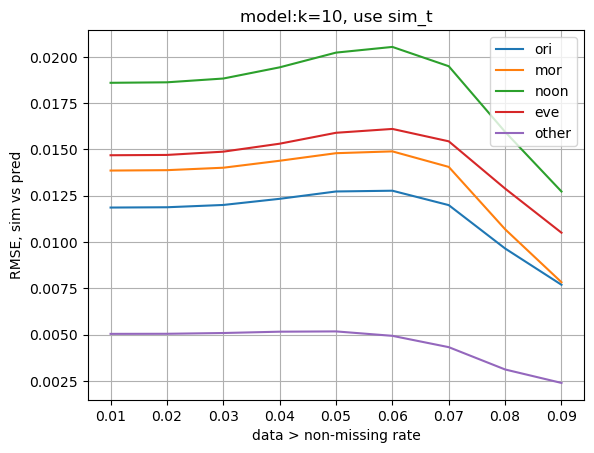

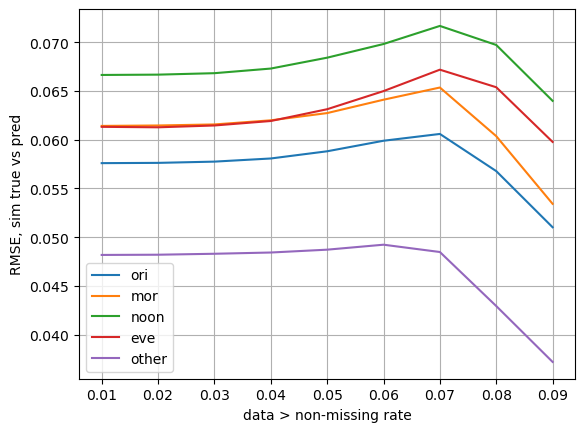

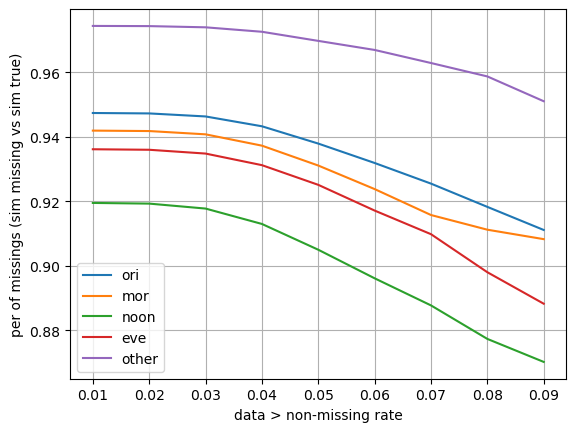

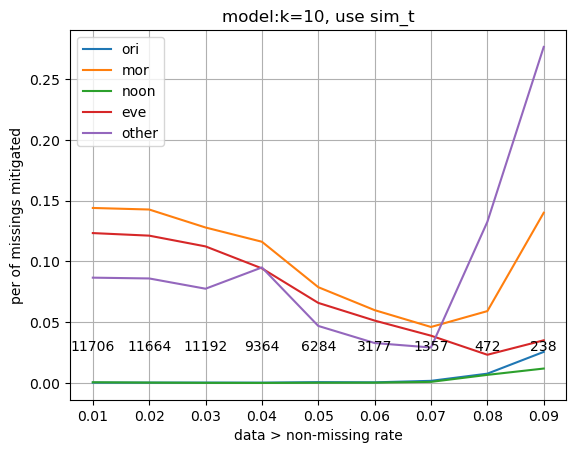

In [91]:
plot_paras(result_para_dict_simt, x_val_simt, 10, 'sim_t', ypop_simt)

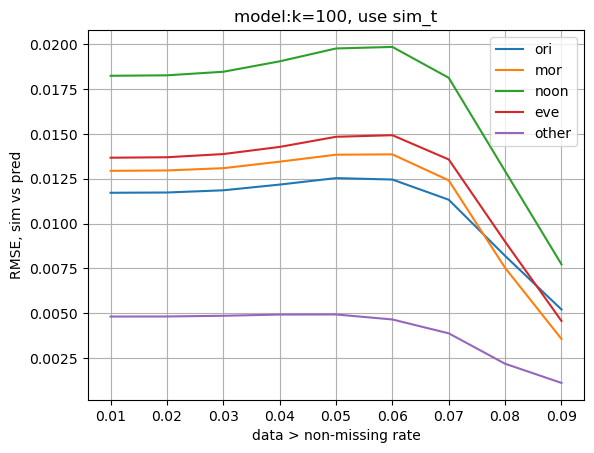

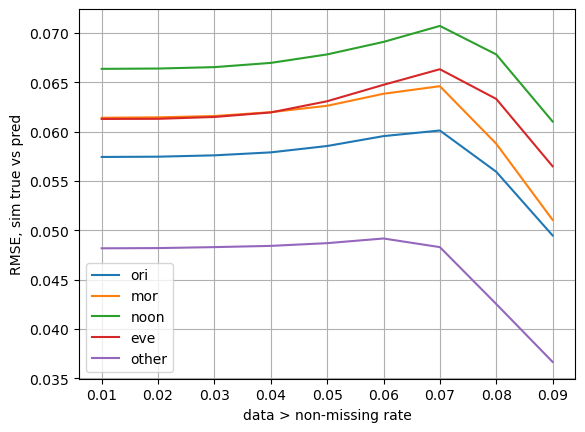

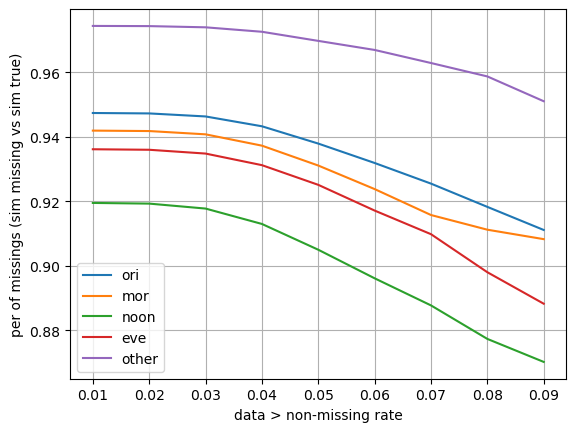

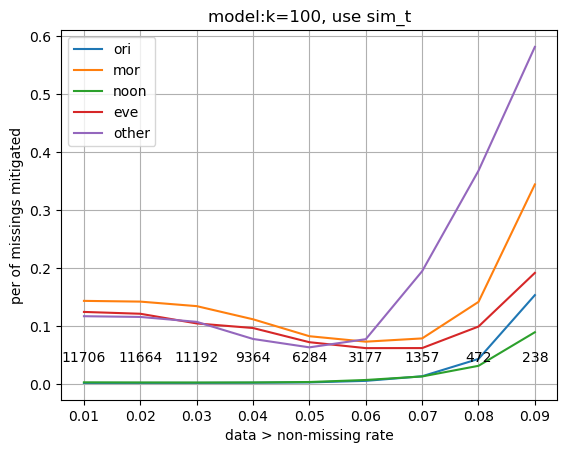

In [92]:
plot_paras(result_para_dict_simt_100, x_val_simt, 100, 'sim_t', ypop_simt)

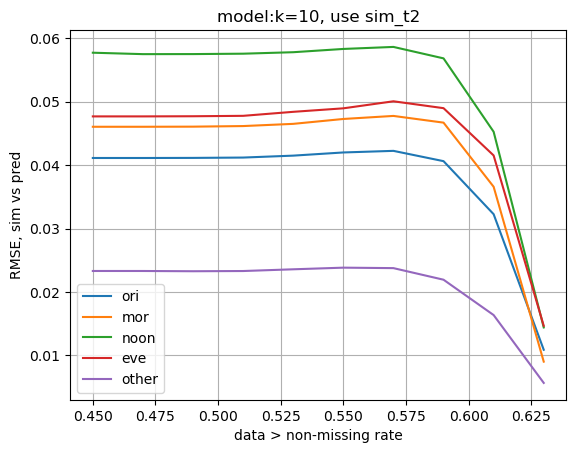

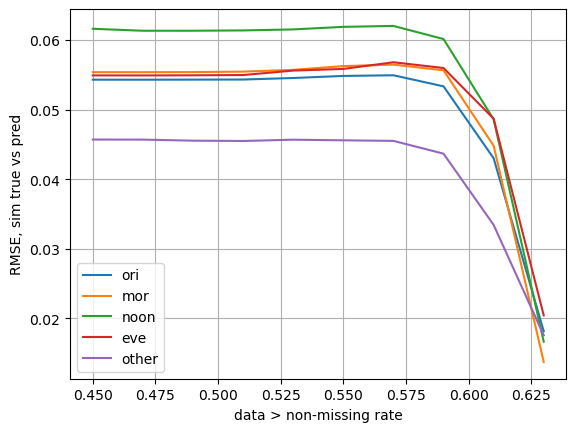

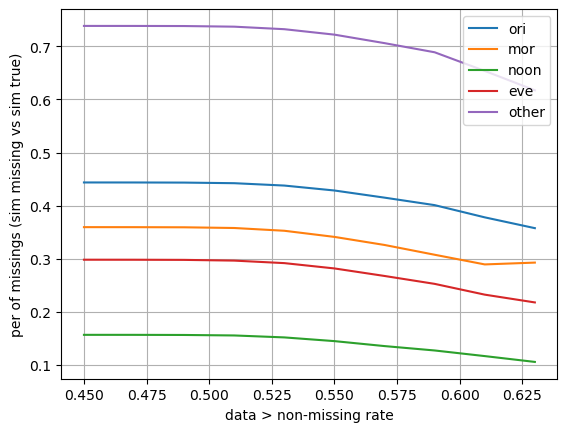

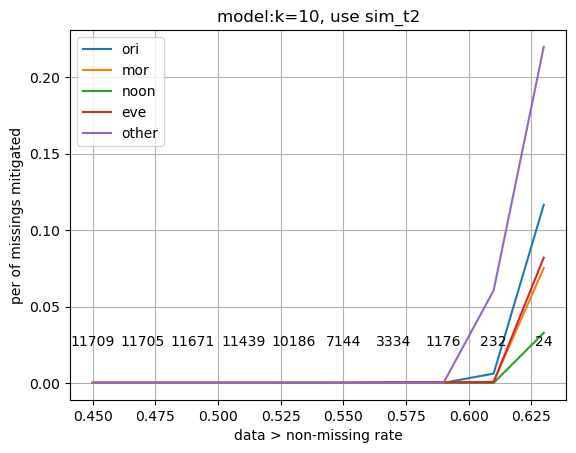

In [93]:
plot_paras(result_para_dict_simt2, x_val, 10, 'sim_t2', ypop_simt2)

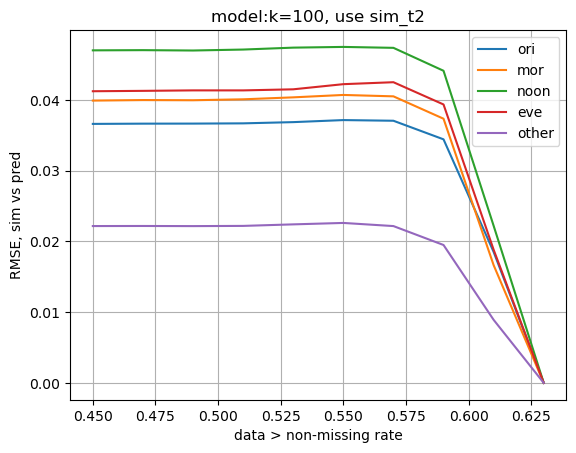

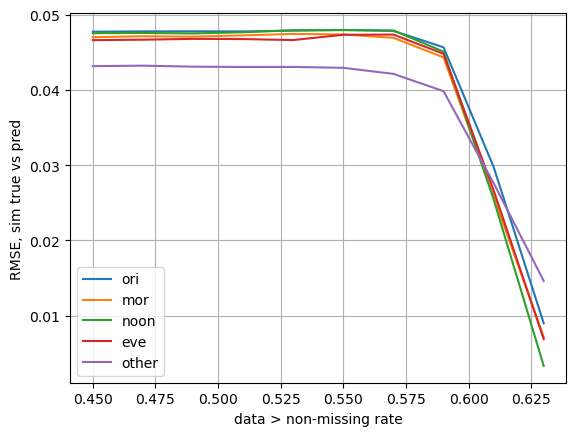

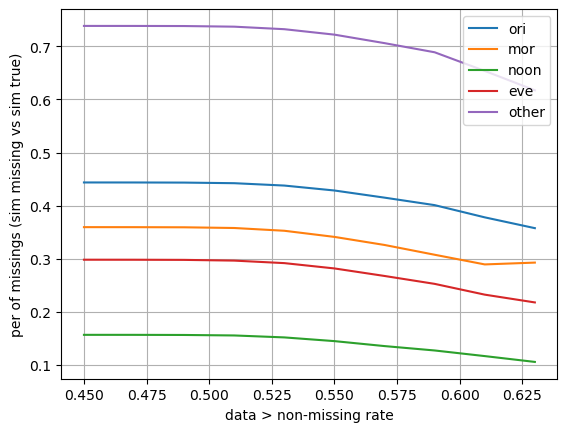

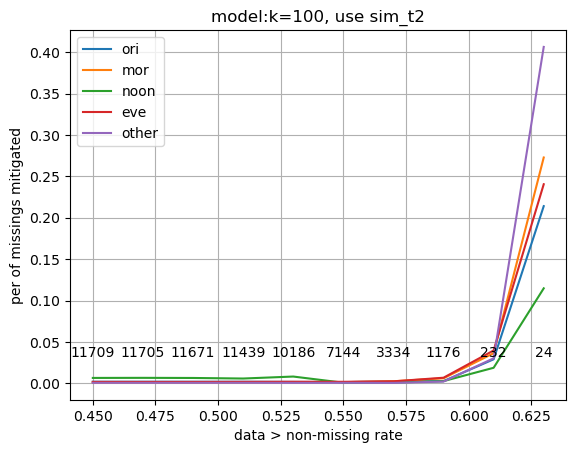

In [94]:
#plot_paras(result_para_dict_simt_100, x_val, 100, 'sim_t')
plot_paras(result_para_dict_simt2_100, x_val, 100, 'sim_t2', ypop_simt2)

In [ ]:
#save_result_dict(result_para_dict_simt, "result_para_dict_simt_k10.txt")
save_result_dict(result_para_dict_sim_t2, "result_para_dict_simt2_k10.txt")
save_result_dict(result_para_dict_simt_100, "result_para_dict_simt_k100.txt")
save_result_dict(result_para_dict_sim_t2_100, "result_para_dict_simt2_k100.txt")

In [ ]:
#data
result_para_dict_simt ={'ori': {'rmse_predvssim': [0.007690334758278416,
   0.011861481770917106,
   0.011877536296354201,
   0.012001591648297517,
   0.012333412474008829,
   0.012729749571966173,
   0.012770963765824813,
   0.011992614263893142,
   0.009650150431630694],
    'rmse_predvstrue': [0.051016427193137544,
   0.057591293538391555,
   0.05761897340150735,
   0.057746840221452135,
   0.05806906215263047,
   0.05880726664682562,
   0.059887635174768555,
   0.060584920113530394,
   0.05677436238546328],
    'per of missings (sim missing vs sim true)': [0.911108193277311,
   0.9473901679100936,
   0.9472590758840116,
   0.946319543721706,
   0.9432730700318003,
   0.9379050189193012,
   0.931887830937642,
   0.9254866740358634,
   0.9182703625235404],
    'per of missings mitigated': [0.02562008614753967,
   0.00036099353686940016,
   0.00036045797961888244,
   0.00036554165076642446,
   0.0003199875464306254,
   0.000742306085790553,
   0.0005793668013440371,
   0.0018053885179502066,
   0.007714738916571868]},                   
    'mor': {'rmse_predvssim': [0.007828231347560718,
   0.013859302799877782,
   0.01388070242604708,
   0.014012703450132393,
   0.014389104925496029,
   0.01479752473155533,
   0.014895481608422963,
   0.014056608880928344,
   0.010688582884434163],  
     'rmse_predvstrue': [0.053418281987026695,
   0.061409481654068586,
   0.06145347607074007,
   0.061559866704815516,
   0.0619822568105651,
   0.06272493392831388,
   0.06409554392871193,
   0.06534559487715583,
   0.060358234150394596],
       'per of missings (sim missing vs sim true)': [0.9082633053221288,
   0.9419291151736052,
   0.941791457094955,
   0.9407736676991502,
   0.9372626845127913,
   0.9310948440483768,
   0.9237925366348407,
   0.9157455170719725,
   0.9111935028248588],
      'per of missings mitigated': [0.14006682086867128,
   0.1439850457495264,
   0.14271409136655355,
   0.12791749879303205,
   0.11620325679289772,
   0.07883742570120968,
   0.05994926932687211,
   0.04611498569384836,
   0.05916166117677453]},
'noon': {'rmse_predvssim': [0.012727082029697806,
   0.018599294114145782,
   0.018625756960884653,
   0.018830281157937768,
   0.01943439020966053,
   0.020230021374531098,
   0.0205370567774557,
   0.019494547469498524,
   0.015948706624935666],
           'rmse_predvstrue': [0.06397895272199196,
   0.06663463440471604,
   0.06666683229718667,
   0.06681604334763545,
   0.06729071592148717,
   0.06840617573166134,
   0.06980675343678953,
   0.0716626726709641,
   0.06970939212550449],
   'per of missings (sim missing vs sim true)': [0.8701855742296919,
   0.9194973019534142,
   0.919286908436214,
   0.9177500297831784,
   0.9129778940623665,
   0.904978583174199,
   0.8961185867170286,
   0.8877118644067796,
   0.8773172669491526],
  'per of missings mitigated': [0.011920329946685444,
   0.0006290470711084486,
   0.00034875836194317667,
   0.00016226193132263758,
   9.503896597605019e-05,
   0.00025826966650242426,
   0.0003292976082017058,
   0.0009511950468679741,
   0.006716474228360123]},
 'eve': {'rmse_predvssim': [0.010502100208879794,
   0.014686795660785661,
   0.014703299983863547,
   0.014880110096300274,
   0.015310394182962388,
   0.015899886455230366,
   0.016107691438151106,
   0.015438681984233605,
   0.012885753461279553],
  'rmse_predvstrue': [0.059767333535504445,
   0.06131457613238765,
   0.06126603262672687,
   0.06145329045786582,
   0.06191236456627443,
   0.06312067571611471,
   0.06497919622359812,
   0.06717567682473358,
   0.06537460640518673],
     'per of missings (sim missing vs sim true)': [0.888235294117647,
   0.9361450782260623,
   0.9359861845972957,
   0.9348080261411212,
   0.9312137670104351,
   0.9251068473219969,
   0.9171275686856424,
   0.909801031687546,
   0.8980024213075061],
  'per of missings mitigated': [0.035139883768076766,
   0.12332745836244746,
   0.12121997241610334,
   0.11237004448595374,
   0.09430005635722617,
   0.06590716967778718,
   0.051363012355363794,
   0.038948415912614845,
   0.023255813953488372]},
'other': {'rmse_predvssim': [0.00238980846981346,
   0.0050391726058245725,
   0.00504378203699889,
   0.005085500808195335,
   0.005156913382794126,
   0.005172363428812574,
   0.004933129317534506,
   0.004321308784059673,
   0.003116114595040795],
  'rmse_predvstrue': [0.0372070395469539,
   0.04817776021159453,
   0.04820066095892989,
   0.048298424827468475,
   0.048426473670651636,
   0.04871799070733817,
   0.04922779459510219,
   0.04847803607771668,
   0.042936930492251904],
'per of missings (sim missing vs sim true)': [0.951038266546288,
   0.9743975329455968,
   0.974339353127232,
   0.9739660560376656,
   0.9725853541433519,
   0.9697565902646628,
   0.9669447501021027,
   0.9628921356663033,
   0.9587302143157305],
'per of missings mitigated': [0.27643493500803273,
   0.0866651885793117,
   0.08601381107795056,
   0.07757608932990441,
   0.09505327673228782,
   0.0469656941988261,
   0.03289661295095639,
   0.029221272074077823,
   0.13260889416491645]}}

result_para_dict_simt2 = {'ori' : {'rmse_predvssim': [
   0.04113807471040142,
   0.041164117749803227,
   0.04127143536381266,
   0.041567190570421526,
   0.04218157313979382,
   0.04286957179349329,
   0.04314950697886612,
   0.03977831916975735,
   0.03485291636914015],
   'rmse_predvstrue': [
   0.05431287678026451,
   0.05435014557879387,
   0.05448716410273881,
   0.05484531430515014,
   0.05568600774637898,
   0.056898355548439354,
   0.05785064294057926,
   0.0542894822785923,
   0.048350428694050526],                                
  'per of missings (sim missing vs sim true)': [
   0.4435424260113522,
   0.44352220983843926,
   0.44348021404177584,
   0.44300497769234415,
   0.4418435930758894,
   0.44063341552128144,
   0.43869493572422824,
   0.433674670433145,
   0.430015756302521],                               
  'per of missings mitigated': [
   2.6081251793086062e-05,
   2.5505170166468218e-05,
   3.4278486821670716e-05,
   5.440650869248604e-05,
   5.377386215132965e-05,
   4.216594033767477e-05,
   3.499582966363175e-05,
   0.0005597774460578097,
   0.001289228159457167]},                       
   'mor': {'rmse_predvssim': [
   0.04597298172474255,
   0.04601717229809827,
   0.046144403277808554,
   0.04660057885888863,
   0.047433923216744577,
   0.048615885076810215,
   0.04945095483562942,
   0.04432818987020974,
   0.03748786965187502],
   'rmse_predvstrue': [
   0.055399036920744674,
   0.05545326415940571,
   0.055584439135866526,
   0.0560854457813578,
   0.057016758976203744,
   0.05866908260866102,
   0.060247286692762074,
   0.05547474858257091,
   0.0486262611766219],
   'per of missings (sim missing vs sim true)': [   
   0.3610636520682651,
   0.36104681069958844,
   0.36098453260265273,
   0.35986223835967535,
   0.35826879553009405,
   0.35694925331374816,
   0.3531073446327684,
   0.3481638418079096,
   0.35049019607843135],
   'per of missings mitigated': [
   5.914904244272401e-05,
   5.936479667557139e-05,
   5.500360961188078e-05,
   4.945965328783045e-05,
   8.636750607657096e-05,
   7.348438456827924e-05,
   0.00017391304347826088,
   0.0005070993914807302,
   0.001665001665001665]},
 'noon': {'rmse_predvssim': [   
   0.05771133952731652,
   0.05752131332133793,
   0.057696402312049665,
   0.05826518868888879,
   0.059471278306711256,
   0.06113525305211396,
   0.06310008390125588,
   0.060859934607045016,
   0.05500693672224737],
   'rmse_predvstrue': [
   0.061613797851948586,
   0.06136875646013456,
   0.06155764213847834,
   0.062160208861244,
   0.0634247441808637,
   0.06523004889329768,
   0.06755932976446813,
   0.06579333521670577,
   0.06027021135687914],
'per of missings (sim missing vs sim true)': [
   0.15658369639501113,
   0.1565429240969365,
   0.15644824428162973,
   0.1560519898903603,
   0.15510622215149583,
   0.15412535410764872,
   0.15278801277327436,
   0.14740024717514122,
   0.14784663865546221],

   'per of missings mitigated': [
   7.956127639019123e-05,
   0.0001597371183423851,
   0.0001606253680998019,
   0.00017108395945310162,
   0.00014962060489473122,
   0.00012764056417129363,
   0.00010048231511254019,
   0.0002994460248540201,
   0.0014801657785671995]},

   'eve': {'rmse_predvssim': [
   0.04778408117262504,
   0.04764011329828683,
   0.04800422124918561,
   0.04851812369380867,
   0.049582772463760964,
   0.05134328993647618,
   0.05309201727423527,
   0.051402812871429435,
   0.04579020178523013],

  'rmse_predvstrue': [
   0.0551453194630221,
   0.054927172653105184,
   0.05538760865662916,
   0.05591716813559445,
   0.05707864368720805,
   0.05919619101862636,
   0.06168663692082968,
   0.06097255155453629,
   0.055411012288502565],
   'per of missings (sim missing vs sim true)': [
   0.2982353371897195,
   0.29829757005682933,
   0.2980955784744205,
   0.29774516384939276,
   0.29651268527780306,
   0.2938171680381312,
   0.29087272344457316,
   0.2889830508474577,
   0.28223289315726285],
   'per of missings mitigated': [
   0.00018004746705949752,
   0.00013959943174819548,
   0.00018840455596471695,
   0.00019470604511031634,
   0.00016867285133788238,
   0.0004897309540571148,
   0.00014477017734346723,
   0.00020946795140343527,
   0.0012760527435133986]},

  'other': {'rmse_predvssim': [
   0.02333749344820515,
   0.023349222593386593,
   0.02337498617324706,
   0.023339796774259253,
   0.023294053769046766,
   0.022940266313281808,
   0.021336176132825502,
   0.016983274665613873,
   0.013727346880013569],

   'rmse_predvstrue': [
   0.045554969162595,
   0.04557929714795551,
   0.04567460178028213,
   0.0457060480675748,
   0.04616244314046175,
   0.04675520401582132,
   0.046085124039845105,
   0.04040245722169883,
   0.034688090977294826],
  
   'per of missings (sim missing vs sim true)': [         
   0.7377822773657078,
   0.7377535172147967,
   0.7378056344850809,
   0.7374241423987065,
   0.7362408004587276,
   0.7353108733484731,
   0.7337527482231709,
   0.7280956716626978,
   0.7202930759080493],
   'per of missings mitigated': [
   8.61232481095947e-06,
   8.643673215369604e-06,
   9.00756635573882e-06,
   1.0771554478932037e-05,
   1.0717903006550425e-05,
   1.7688720963964538e-05,
   2.4900398406374503e-05,
   0.0004569174903205637,
   0.006267174468495396]}}

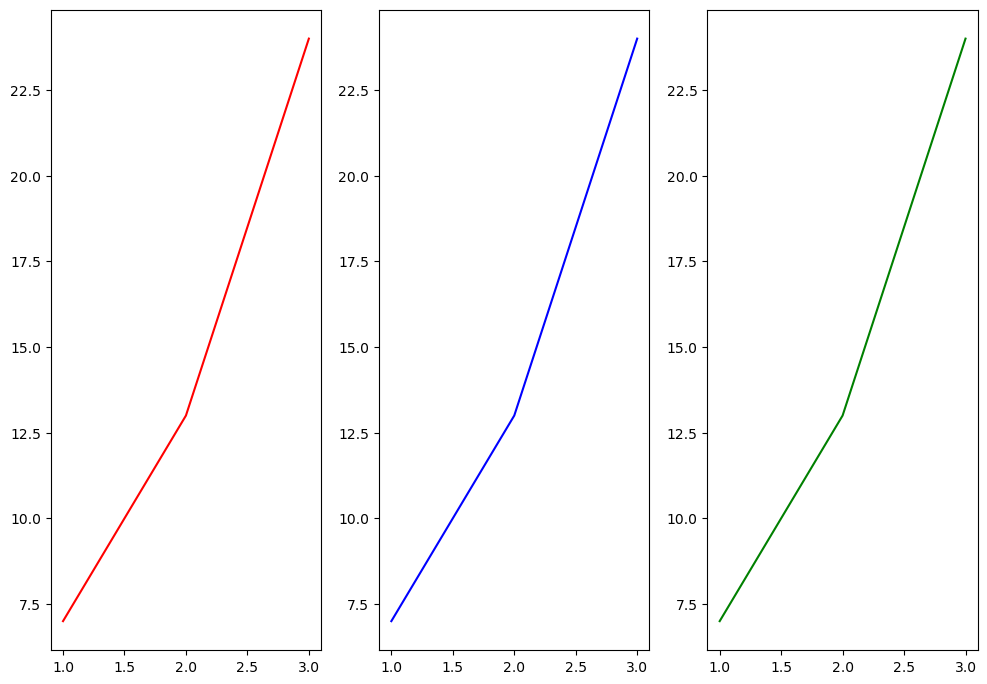

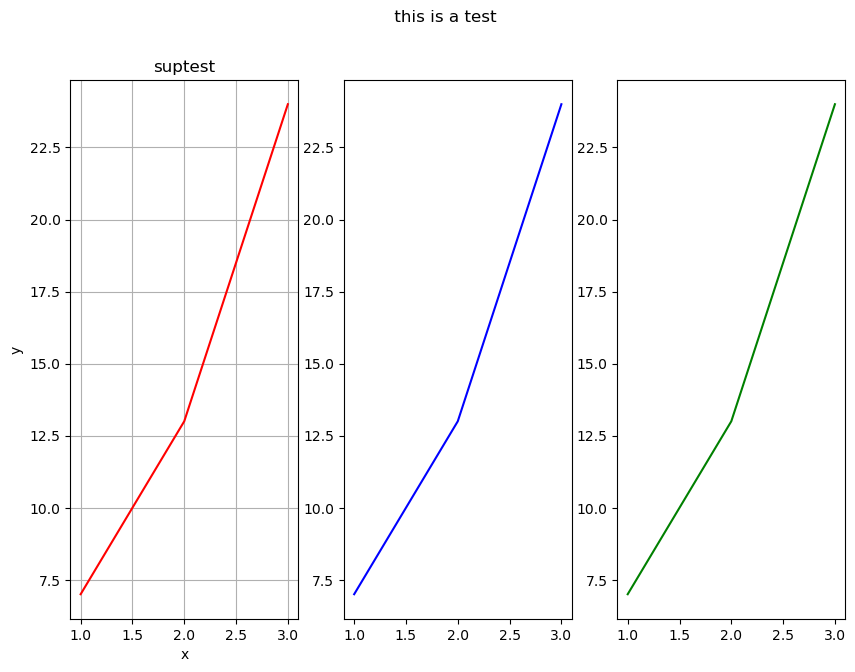

In [90]:
fig, ax = plt.subplots(1, 3, figsize=(10,7))
fig.tight_layout()

#define data
x = [1, 2, 3]
y = [7, 13, 24]

#create subplots
ax[0].plot(x, y, color='red')
ax[1].plot(x, y, color='blue')
ax[2].plot(x, y, color='green')
#ax[1, 1].plot(x, y, color='purple')

fig, ax = plt.subplots(1, 3, figsize=(10,7))
#fig.tight_layout()

#define data
x = [1, 2, 3]
y = [7, 13, 24]

fig.suptitle(' this is a test ')
#create subplots
ax[0].plot(x, y, color='red')
ax[0].grid()
ax[0].set_title('suptest')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].plot(x, y, color='blue')
ax[2].plot(x, y, color='green')

In [30]:
k_val = 10

model = NMF(n_components=k_val, init='random', random_state=0)

W = model.fit_transform(sim_dt_all_wmiss)
H = model.components_

pred_dt = np.dot(W, H)

#pred vs. data with missings
model_rmse_wm = mean_squared_error(sim_dt_all_wmiss, pred_dt, squared=False)
#pred vs. true data
model_rmse_t = mean_squared_error(sim_dt_all, pred_dt, squared=False)

In [45]:
b.append(model_rmse_wm)

In [46]:
b.append(model_rmse_t)

num taz 174


num taz 174


num taz 174


0.5403461605982103

0.5396932144014379

In [62]:
mean_squared_error(WH_index_mis, WH_index_tru, squared=False)

30.116392508759784

In [56]:
np.unique(WH_index_tru)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173], dtype=int64)

In [57]:
np.unique(WH_index)

array([  5,   6,   7,   8,  14,  16, 109, 142, 150, 159, 164, 168, 169,
       170, 171, 172, 173], dtype=int64)

In [59]:
np.unique(WH_index_mis)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173], dtype=int64)

In [41]:
WH_index.shape

(11709, 288)

In [40]:
pred_dt[WH_index]

MemoryError: Unable to allocate 1.23 TiB for an array with shape (11709, 288, 50112) and data type float64

In [14]:
a = np.zeros((3,5))
for i in range(a.shape[0]):
    a[i, np.random.choice(list(range(5)))] = 1


In [206]:
type(a[np.where(a>0)])

numpy.ndarray

In [210]:
np.random.choice(list(range(non_zero_loc.shape[1])),size=int((non_zero_loc.shape[1])*missing_rate))

array([2793795,  202994, 2887327, ...,  506640, 2225479, 1055212])

In [167]:
#def fit_process_dt_nmf(sim_dt, missing_info, missing_val, k_val): 
    #predict data based on time



del(W, H)
print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val), model_rmse) 

array([    0, 31676], dtype=int64)

In [168]:
np.where(sim_dt_all>0)

(array([    0,     0,     0, ..., 11708, 11708, 11708], dtype=int64),
 array([31676, 32896, 33026, ..., 48957, 48958, 48959], dtype=int64))

In [141]:
###csv 2 fit data using r, 
###r dir: G:/My Drive/2021/Bias/PSRC_od_simulation_2018/ts_data_correlation.R
taz_time = fcd_dt.groupby(by=['taz', 'time_5_new']).size().to_frame()
taz_time.reset_index(inplace=True)
taz_time.columns = ['taz', 'time_5_new', 'num']

taz_time = taz_time[taz_time['taz']<=1000]
taz_dict = {}
idx = 0
for i in np.unique(taz_time.taz):
    #print(i)
    if i not in taz_dict:
        taz_dict[i] = idx
        idx+=1
        
get_tazid = lambda x: taz_dict[x]
taz_time['taz_id'] = taz_time['taz'].apply(get_tazid)
taz_total = ((fcd_dt[fcd_dt['taz']<1000]).groupby(by=['taz','reids']).size().to_frame()).groupby(by=['taz']).size().to_frame()
sum_val_sim = taz_total[0].values

origin_dt = pd.read_csv('../data-1670309862526.csv')
origin_dt.columns
sum_val_cuebiq = (origin_dt.groupby(by=['taz','newid']).size().to_frame()).groupby(by=['taz']).size().to_frame()
sum_val_cuebiq = sum_val_cuebiq[0].values

origin_dt = pd.read_csv('../data-1670309862526.csv')
get_time_5 = lambda x: int(x.split(':')[0])*12+int((int(x.split(':')[1]))/5)
origin_dt['time_5'] = origin_dt['time'].apply(get_time_5)

origin_dt = origin_dt.groupby(by=['taz','time_5']).size().to_frame()
origin_dt.reset_index(inplace=True)
origin_dt.columns = ['taz','time_5', 'num']

taz_dict = {}
idx = 0
for i in np.unique(origin_dt.taz):
    if i not in taz_dict:
        taz_dict[i] = idx
        idx += 1
origin_dt['taz_id'] = origin_dt['taz'].apply(get_tazid)

def convert_2mx(df, taz_col, time_col, val_col, sums_):
    origin_mx = np.zeros((len(np.unique(df[taz_col])), len(np.unique(df[time_col]))))
    for i in range(df.shape[0]):
        origin_mx[df[taz_col][i], df[time_col][i]] = df[val_col][i]
        
    num_taz = len(np.unique(df[taz_col]))
    taz_ = np.unique(df['taz']).reshape(num_taz, 1)
    sums_ = sums_.reshape(num_taz, 1)
    return(np.hstack((taz_, origin_mx, sums_)))

taz_time = convert_2mx(taz_time, 'taz_id', 'time_5_new', 'num', sum_val_sim)
origin_dt = convert_2mx(origin_dt, 'taz_id', 'time_5', 'num', sum_val_cuebiq)

#taz_time.to_csv('sim_taz_num.csv')
#origin_dt.to_csv('cuebiq_num.csv')
pd.DataFrame(taz_time).to_csv('sim_taz_num.csv')
pd.DataFrame(origin_dt).to_csv('cuebiq_num.csv')

In [ ]:
#algorithm, nmf test
WH_ts = fit_dt(fcd_dt, 'sim_t', 100)
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_t_100_ht10per_withstay.csv')
#pd.DataFrame(WH_index).to_csv('WH_index_t_100_ht10per_withstay.csv')
#del(WH_ts, WH_max, WH_index)

WH_ts = fit_dt01(fcd_dt, 'sim_ts', 100)
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_ts_100_ht10per_withstay_01.csv')
pd.DataFrame(WH_index).to_csv('WH_index_ts_100_ht10per_withstay_01.csv')
del(WH_ts, WH_max, WH_index)

fit_dtbytime_stay(fcd_dt, 'sim_t', 12, 100, '100t_ht10per01')

fit_dtbytime_stay(fcd_dt, 'sim_ts', 12, 100, '100ts_ht10per01')

In [ ]:
#fcd_dt = pd.read_csv('fcd_dt_ht_with_stay_Seadt.csv', index_col=0)
fcd_dt = pd.read_csv('fcd_dt_all_with_stay_Seadt.csv', index_col=0)

#algorithm, nmf test
WH_ts = fit_dt(fcd_dt, 'sim_t', 100)
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_t_100_all10pe_withstay.csv')
pd.DataFrame(WH_index).to_csv('WH_index_t_100_all10pe_withstay.csv')
del(WH_ts, WH_max, WH_index)

WH_ts = fit_dt(fcd_dt, 'sim_ts', 100)
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_ts_100_all10pe_withstay.csv')
pd.DataFrame(WH_index).to_csv('WH_index_ts_100_all10pe_withstay.csv')
del(WH_ts, WH_max, WH_index)

fit_dtbytime_stay(fcd_dt, 'sim_t', 12, 100, '100t_all10pe')

fit_dtbytime_stay(fcd_dt, 'sim_ts', 12, 100, '100ts_all10pe')

### Surprise application

In [2]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise import SVDpp
from surprise import get_dataset_dir, dump
from surprise.model_selection import train_test_split
from surprise import KNNBasic, KNNWithMeans, KNNBaseline, KNNWithZScore
from surprise import NormalPredictor
#from surprise import NMF

In [27]:
#from surprise import BMF

In [10]:
#check similarity
len(np.unique(fcd_dt['reids']))

11709

In [11]:
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(fcd_dt[['id_index', 'ts_index', 'sim_t']], 
                            reader=reader)

In [12]:
train = data.build_full_trainset()
#test = data.build_anti_testset()

In [13]:
train.n_users

11709

In [14]:
train.n_items

49052

In [272]:
algo = NormalPredictor()
algo.fit(train)
predictions = algo.test(train.build_testset())
accuracy.rmse(predictions)

RMSE: 0.2631


0.263052824716942

In [273]:
algo = SVD()
algo.fit(train)
predictions = algo.test(train.build_testset())
accuracy.rmse(predictions)
del(predictions)

RMSE: 0.2012


0.20116639097274144

In [281]:
algo = KNNBaseline()
algo.fit(train)

predictions_KNN = algo.test(train.build_testset())
accuracy.rmse(predictions_KNN)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1949


0.19494840144804554

In [17]:
#similarities between items
sim_options = {'name': 'cosine',
              'user_based': True}

algo = KNNBasic(sim_options=sim_options)
algo.fit(train)

predictions_KNN = algo.test(train.build_testset())
accuracy.rmse(predictions_KNN)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.1554


0.15539946341857047

In [18]:
#similarities between items
sim_options = {'name': 'pearson',
              'user_based': True}

algo = KNNBasic(sim_options=sim_options)
algo.fit(train)

predictions_KNN = algo.test(train.build_testset())
accuracy.rmse(predictions_KNN)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1386


0.13862897242064817

In [19]:
#'MSD'
algo = KNNBasic(sim_options=sim_options)
algo.fit(train)

predictions_KNN = algo.test(train.build_testset())
accuracy.rmse(predictions_KNN)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1386


0.13862897242064817

In [51]:
#similarities between items
sim_options = {'name': 'pearson_baseline',
              'user_based': True}

algo = KNNBasic(sim_options=sim_options)
algo.fit(train)

predictions_KNN = algo.test(train.build_testset())
accuracy.rmse(predictions_KNN)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1237


0.12368558609025071

In [50]:
for i in (fcd_dt[(fcd_dt['id_index']==0)&(fcd_dt['sim_t']==1)]).ts_index:
    print(algo.predict(0, i, verbose=True))

user: 0          item: 48672      r_ui = None   est = 0.98   {'actual_k': 40, 'was_impossible': False}
user: 0          item: 48672      r_ui = None   est = 0.98   {'actual_k': 40, 'was_impossible': False}
user: 0          item: 39539      r_ui = None   est = 0.90   {'actual_k': 5, 'was_impossible': False}
user: 0          item: 39539      r_ui = None   est = 0.90   {'actual_k': 5, 'was_impossible': False}
user: 0          item: 39545      r_ui = None   est = 0.33   {'actual_k': 21, 'was_impossible': False}
user: 0          item: 39545      r_ui = None   est = 0.33   {'actual_k': 21, 'was_impossible': False}
user: 0          item: 39546      r_ui = None   est = 0.53   {'actual_k': 13, 'was_impossible': False}
user: 0          item: 39546      r_ui = None   est = 0.53   {'actual_k': 13, 'was_impossible': False}
user: 0          item: 39575      r_ui = None   est = 0.57   {'actual_k': 14, 'was_impossible': False}
user: 0          item: 39575      r_ui = None   est = 0.57   {'actual_k': 1

In [ ]:
#using BMF
#import numpy as np
from sklearn.decomposition import NMF

# Load the data into a Numpy array
#ratings = np.loadtxt('ratings.csv', delimiter=',')

# Create the user-item matrix
user_item_matrix = np.zeros((num_users, num_items))
for i in range(ratings.shape[0]):
    user_item_matrix[ratings[i, 0]-1, ratings[i, 1]-1] = ratings[i, 2]

# Initialize the NMF model with binary options
model = NMF(n_components=k, init='random', random_state=0, solver='cd', beta_loss='binary_reconstruction')

# Fit the model to the user-item matrix
W = model.fit_transform(user_item_matrix)
H = model.components_

# Predict the ratings for the test set
predictions = np.dot(W, H)
